# Open problems - Single cell perturbations
## EDA + Deep learning-based approach
#### by Antoine Passemiers

---

## Table of contents:
* [Data Exploration](#data-exploration)
  * [Cells counts and prevalence of biases in Limma](#limma-limitations)
  * [Cells have dissimilar responses to treatments](#correlations)
  * [Differentially-expressed genes and housekeeping genes](#housekeeping_genes)
  * [Which chemical descriptors are actually useful?](#chemical_descriptors)
  * [Interpolation vs Extrapolation](#interpolation_vs_extrapolation)
* [Model design](#model-design)
  * [Preprocessing - Encoding the categories](#encoding-categories)
  * [Integration of prior knowledge in the form of biological networks](#biological-networks)
    * [Gene - Pathway](#biological-network-pathways)
    * [Gene regulatory network](#biological-networks-grn)
    * [Coaccessibility network](#biological-network-coaccessibility)
    * [Biologically-Meaningul Sparsified Linear Layer](#bms-layer)
  * [Regularization](#regularization)
  * [Neural architecture](#neural-architecture)
* [Cross-validation strategy](#cross-validation)
* [Model reliability](#model-reliability)
  * [The NN's prediction mechanism reflects gene regulatory relationships](#interpretability-grn)
  * [The NN is robust against random fluctuations of the inputs](#robustness)
* [Make submission](#make-submission)
* [Future work](#future_work)
* [Bibliography](#bibliography)

This notebook contains both EDA and ML code for the Kaggle competition ["Open Problems – Single-Cell Perturbations"](#ref_kaggle).

The problem at hand is an <span style="color:crimson;">extrapolation</span> problem. Indeed, we are tasked to model differential expression (DE) for unknown combinations of cell types and compounds ``(cell_type, sm_name)``, where unknown pairs involve only myeloid cells, which respond to treatments in drastically different manners compared to lymphoid cells. Because tree-based models (e.g., Random Forests) cannot extrapolate from training data, neural networks should *a priori* have an upper hand. However, extrapolation abilities is a double-edged sword, as the performance metric used to evaluate contenders is the mean of per-row root mean squared errors, therefore produced large error terms for large DE values.

We hypothesize that the difficulties faced by all the competitors and the overall low performance of top solutions can be attributed, to a large extent, to the choice of the evaluation metric itself (MRRMSE). Indeed, ground-truth DE values have been produced by the organizers using the ``Limma`` package. For each gene, compound and cell type, ``Limma`` estimates a p-value, and jointly corrects them all using an Empirical Bayes approach. Because the library combines many pre-processing steps, statistical concepts, linear algebra tricks and fairy dust, it makes it practically impossible to anticipate when it will produce a p-value of 1e-28 or 1e-42, as both cases correspond to a highly significant differential expression. However this tiny difference <span style="color:crimson;">can alone produce an error term of $14^2 = 196$</span>, even if the model accurately captures the significance in DE. An alternative could have been to reduce the problem to a classification problem, where DE is either significantly positive, significantly negative, or non-significant.


#### Import libraries

In [1]:
!pip install rdkit category_encoders captum portia-grn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.9/365.9 kB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for portia-grn: filename=portia_grn-0.0.21-py3-none-any.whl size=37797 sha256=fcefac36ce00e1e049a2bc686b7484ed08ee7b95e8878abaa4795950f3735009
  Stored in directory: /root/.cache/pip/wheels/c4/41/2e/8e901e633bb41cfb852bb756f5a7edf99603521bbe1f151029
Successfully built portia-grn


In [2]:
SEED = 0xCAFE
USE_GPU = True

In [3]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Make PyTorch deterministic on GPU

import json
import math
import random
import warnings
import collections
from typing import Dict, List, Tuple, Optional, Generator

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats
import scipy.sparse
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import KernelPCA
from sklearn.metrics import matthews_corrcoef, roc_auc_score, average_precision_score
import pandas as pd
import tqdm
import torch

import portia
import category_encoders
from captum.attr import IntegratedGradients
from rdkit import rdBase, Chem, DataStructs
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import FunctionalGroups
from rdkit.Chem.AtomPairs import Pairs, Torsions, Sheridan

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Reproducibility and GPU use

This notebook was run on Kaggle's online editor, using GPU T100 acceleration.

In [4]:
if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')
    USE_GPU = False
    
# Make Python deterministic?
os.environ['PYTHONHASHSEED'] = str(int(SEED))

# Make PyTorch deterministic
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(1)

    
def plant_seed(seed: int) -> None:
    """Set seed for reproducibility purposes.
    
    Applies to the `random`, `numpy` and `torch` packages.
    
    Args:
        seed: Seed state.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if USE_GPU:
        torch.cuda.manual_seed_all(seed)

        
plant_seed(SEED)

using device: cuda


#### Load data

This notebook focuses on the modelling of DE values without having recourse to the raw expression data. For this reason, we only load the DE data and the cell metadata.

In [5]:
# Data location
DATA_FOLDER = '/kaggle/input/open-problems-single-cell-perturbations/'

# Cell types for which all compounds are available in training set
TRAIN_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

# Cell types for which some compounds are available in test set
TEST_CELL_TYPES = ['Myeloid cells', 'B cells']

# All cell types
CELL_TYPES = TRAIN_CELL_TYPES + TEST_CELL_TYPES

# Load DE data, as well as the cell type, compound and SMILES for each row
df = pd.read_parquet(os.path.join(DATA_FOLDER, 'de_train.parquet'))
cell_types = df['cell_type']
sm_names = df['sm_name']
all_smiles = df['SMILES']

# Convert Pandas dataframe to NumPy array
for col_name in ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']:
    df.drop(col_name, axis=1, inplace=True)
data = df.to_numpy(dtype=float)

# Gene names, ordered by columns
gene_names = list(df.columns)
gene_name_dict = {gene_name: i for i, gene_name in enumerate(gene_names)}

# Unique compound names and cell types
unique_sm_names = list(set(sm_names))
unique_cell_types = list(set(cell_types))

# Dict to map compounds to their SMILES
sm_name_to_smiles = {sm_name: smiles for sm_name, smiles in zip(sm_names, all_smiles)}

# Make a dict version of the data matrix, to easily access the DE values
# given the cell type and compound
data_dict = {}
for p in range(len(sm_names)):
    if sm_names[p] not in data_dict:
        data_dict[sm_names[p]] = {}
    data_dict[sm_names[p]][cell_types[p]] = data[p, :]

# Identify compounds for which all cell types are available
train_sm_names = set()
for sm_name in data_dict.keys():
    if len(data_dict[sm_name]) == len(unique_cell_types):
        train_sm_names.add(sm_name)

# Count, for each (cell_type, compound) pair, how many cells were used to infer the DE values
df = pd.read_csv(os.path.join(DATA_FOLDER, 'adata_obs_meta.csv'), header='infer', delimiter=',')
cell_count_dict = collections.Counter(zip(df['cell_type'], df['sm_name']))
cell_count_per_donor_dict = collections.Counter(zip(df['cell_type'], df['sm_name'], df['donor_id']))
cell_counts = np.asarray([cell_count_dict[key] for key in zip(cell_types, sm_names)])

<h1 id="data-exploration">Data exploration</h1> <a class="anchor" id="data-exploration"></a>

<h2 id="limma-limitations">Cells counts and prevalence of biases in Limma</h2> <a class="anchor" id="limma-limitations"></a>

[Limma](#ref_limma) uses linear models to account for the presence of confounders (e.g., plate, donor). In particular, for this competition the donor ID, plate ID, row ID and compound were all modeled as categorical variables. Because categorical variables require one-hot-encoding, the actual number of (binary) covariates in the model can be rather large (144 compounds + 8 rows + 6 plates + 3 donors - 4 colinear variables). When the number of pseudo-bulked samples is lower than this number, it leads to the <span style="color:crimson;">underdetermination</span> of the problem, therefore making the estimation of the linear coefficients unreliable.

Motivated by these limitations, we checked whether the number of cells used to infer DE for a given `(cell_type, sm_name)` pqir affects the results, in particular the fraction of genes with positive DE. In principle, this fraction can be reasonably expected to be constant.

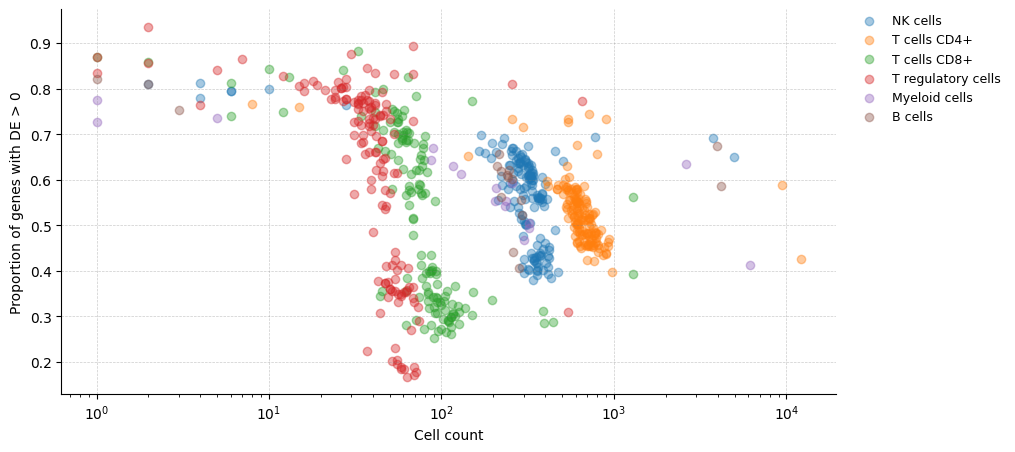

In [6]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
for cell_type in CELL_TYPES:
    mask = (cell_types == cell_type)  # One separate color for each cell type
    plt.scatter(cell_counts[mask], np.mean(data > 0, axis=1)[mask], label=cell_type, alpha=0.4)
plt.xlabel('Cell count')
plt.ylabel('Proportion of genes with DE > 0')
plt.xscale('log')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()

So far, we observe three unexpected behaviors. First, for each cell type there is a clear (negative) linear relationship between the cell counts and the proportion of genes with positive DE. Next, each cell type seems to segregate into 2 clusters, and the strength of this segregation increases from right to left. The fact that the clustering effect is more prominent when the cell count is low suggests that these clusters have no or little biological basis. Finally, all pseudo-bulked samples with cell count < 25 have the majority of their genes positively expressed compared to negative controls.

These patterns are difficult to explain *a priori* and might be mostly artifacts related to the way Limma preprocesses and postprocesses the contrasts. Indeed, while Limma builds on strong statistical bases, in practice the large number of steps turns the library into a deep blackbox:
- The ``voom`` function [normalizes](#ref_voom) the read counts by learning the mean-variance relationship using LOWESS. Each gene and sample is given a weight defined as the inverse of smoothed variance.
- The ``lmFit`` function quantifies the impact of each covariate (i.e., compound, donor, etc.) on the normalized read counts using linear models, with weights estimated by the ``voom`` function. Underdetermination is alleviated using linear algebra tricks.
- The ``contrasts_fit`` function transforms the model by replacing the covariates by their contrasts. In the present context, the variables of interest are the contrasts between the negative controls and each of the compounds.
- Finally, the ``eBayes`` function squeezes the residual variances to avoid producing aberrant t-statistics, using an [Empirical Bayes](#ref_ebayes) approach.

Because the ``voom`` and ``eBayes`` rely on many assumptions, each of them is likely to introduce biases in the data.

Next question is, are the cell type proportions consistent with what can be expected in Peripheral Blood Mononuclear Cells?

[Peripheral Blood Mononuclear Cells](#ref_verhoeckx) have the following cell type frequencies, assuming myeloid cells include mostly monocytes and myeloid dendritic cells, and assuming regulatory T cells account for 5-10% of CD4+ T cells:
- CD4+ T cells: 33-51%
- CD8+ T cells: 16-26%
- NK cells: 3-18%
- B cells: 3-9%
- Myeloid cells: 11-22%
- Regulatory T cells: 1-5%

Let's check whether each donor satisfies these ranges. Because many samples (Myeloid and B cells) have been left out as a test set, we sum the cells only across the compounds which are available in the training set for all cell types including myeloid and B cells. We refer to these compounds as "training" compounds.

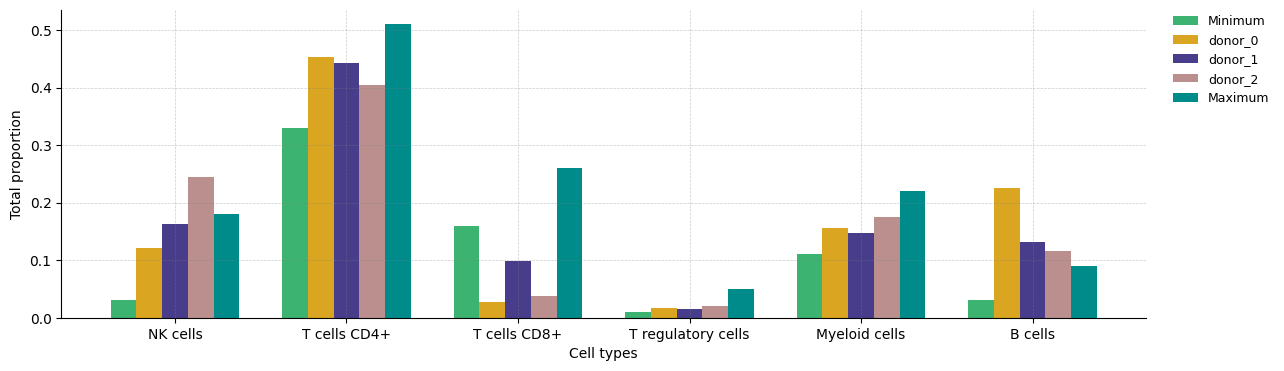

In [7]:
total_counts_per_donor = {'donor_0': {}, 'donor_1': {}, 'donor_2': {}}
for donor_id in total_counts_per_donor.keys():
    for cell_type in CELL_TYPES:
        total_counts_per_donor[donor_id][cell_type] = sum([cell_count_per_donor_dict[(cell_type, sm_name, donor_id)] for sm_name in train_sm_names])
    
BOUNDS = {'NK cells': (0.03, 0.18), 'T cells CD4+': (0.33, 0.51), 'T cells CD8+': (0.16, 0.26), 'T regulatory cells': (0.01, 0.05), 'Myeloid cells': (0.11, 0.22), 'B cells': (0.03, 0.09)}
plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 1, 1)
width = 0.15
plt.bar(np.arange(len(CELL_TYPES))-0.3, [BOUNDS[cell_type][0] for cell_type in CELL_TYPES], label='Minimum', width=width, color='mediumseagreen')
for i in range(3):
    color = ['goldenrod', 'darkslateblue', 'rosybrown'][i]
    proportions = [total_counts_per_donor[f'donor_{i}'][cell_type] / sum(total_counts_per_donor[f'donor_{i}'].values()) for cell_type in CELL_TYPES]
    plt.bar(np.arange(len(CELL_TYPES))-0.15+0.15*i, proportions, label=f'donor_{i}', width=width, color=color)
plt.bar(np.arange(len(CELL_TYPES))+0.3, [BOUNDS[cell_type][1] for cell_type in CELL_TYPES], label='Maximum', width=width, color='darkcyan')
plt.xlabel('Cell types')
plt.xticks(np.arange(len(CELL_TYPES)), CELL_TYPES)
plt.ylabel('Total proportion')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()


These proportions are mostly consistent with the literature, despite a very high proportion of B cells in donor 0, a high proportion of natural killer cells in donor 3, and low proportions of CD8+ T cells in all donors.

Coming back to the previous figure showing the relationship between cell count and proportion of positively DE genes, we haven't checked the relationship with compounds. In the figure below, we reported the same data, but coloring data points (samples) by compound instead, and excluding all "test compounds" (compounds for which we don't have the ground-truth data in myeloid and B cells).

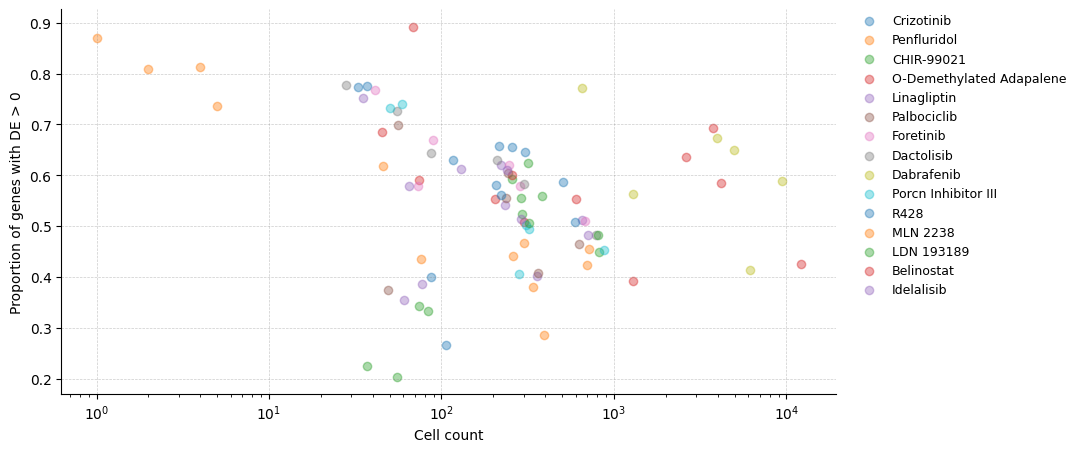

In [8]:
plt.figure(figsize=(10, 5))
xs = cell_counts
ys = np.mean(data > 0, axis=1)  # Proportion of genes with strictly positive DE
ax = plt.subplot(1, 1, 1)

for sm_name in train_sm_names:
    # One separate color for compound
    mask = np.asarray([sm_name == x for x in sm_names], dtype=bool)
    plt.scatter(xs[mask], ys[mask], alpha=0.4, label=sm_name)

plt.xlabel('Cell count')
plt.ylabel('Proportion of genes with DE > 0')
plt.xscale('log')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()

As expected, the pseudo-bulked samples with highest cell counts correspond to the positive controls, namely the ones treated with Dabrafenib and Belinostat. Indeed, these 2 compounds have been used each in one well of each row of each plate, making them 16 times more frequent than other compounds.

Unfortunately, 4 out of the 6 pseudo-bulked samples treated with MLN 2238 have considerably lower cell counts. For this reason, DE values for MLN 2238 might be strongly unreliable. We tried removing them from the training data, however we did not notice any improvement in performance. More generally-speaking, any idea we had on accounting for the cell counts failed miserably.

In the last figure below, we report the standard deviation of DE values (computed across genes) for each pseudo-bulked sample, as a function of the cell count. We observe a strong volatility for low and high cell counts. Since high cell counts correspond to positive controls, it is very likely that this variability is caused by a real biological signal. However this is unexpected for the low cell counts, due to:
- the lack of experimental evidence for producing significant results (low p-values / large DE values),
- the lower volatility for cell counts in the 25-1000 range. 


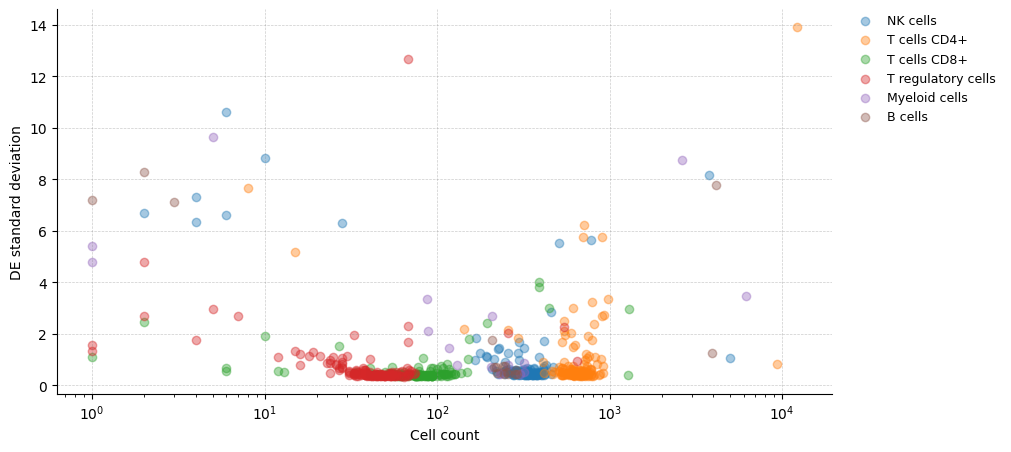

In [9]:
plt.figure(figsize=(10, 5))
xs = cell_counts
ys = np.std(np.abs(data), axis=1)
ax = plt.subplot(1, 1, 1)
for cell_type in CELL_TYPES:
    mask = (cell_types == cell_type)
    plt.scatter(xs[mask], ys[mask], label=cell_type, alpha=0.4)
plt.xlabel('Cell count')
plt.ylabel('DE standard deviation')
plt.xscale('log')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
#plt.axvline(x=25, linestyle='--', linewidth=1, color='black')
plt.show()

<h2 id="correlations">Cells have dissimilar responses to treatments</h2> <a class="anchor" id="correlations"></a>

Before trying to extrapolate the effects of compounds from one cell type to another, let's first assess to what extent this is feasible. For different pairs of cell types, we first compute Pearson's correlation coefficient (computed across genes) for all pairs of "training" compounds.

In [10]:
def plot_comparison(cell_type_a: str, cell_type_b: str, sm_names_: List[str]) -> None:
    """Show the correlations between 2 cell types for each pair of "training" compound,
    using a heatmap.
    
    Args:
        cell_type_a: First cell type (x-axis).
        cell_type_b: Second cell type (y-axis).
        sm_names_: List of compounds to be compared, pairwise.
    """
    corr = np.ones((len(train_sm_names), len(train_sm_names)))
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            # Compute Pearson correlation coefficient
            corr[i, j] = scipy.stats.pearsonr(
                data_dict[sm_names_[i]][cell_type_a],
                data_dict[sm_names_[j]][cell_type_b],
            )[0]
    plt.imshow(corr, cmap='PuOr', vmin=-1, vmax=1)
    plt.xlabel(cell_type_a)
    plt.ylabel(cell_type_b)
    plt.xticks(range(len(sm_names_)), sm_names_, rotation=90)
    plt.yticks(range(len(sm_names_)), sm_names_)
    plt.colorbar()

Let's first compare compounds for each cell type separately.

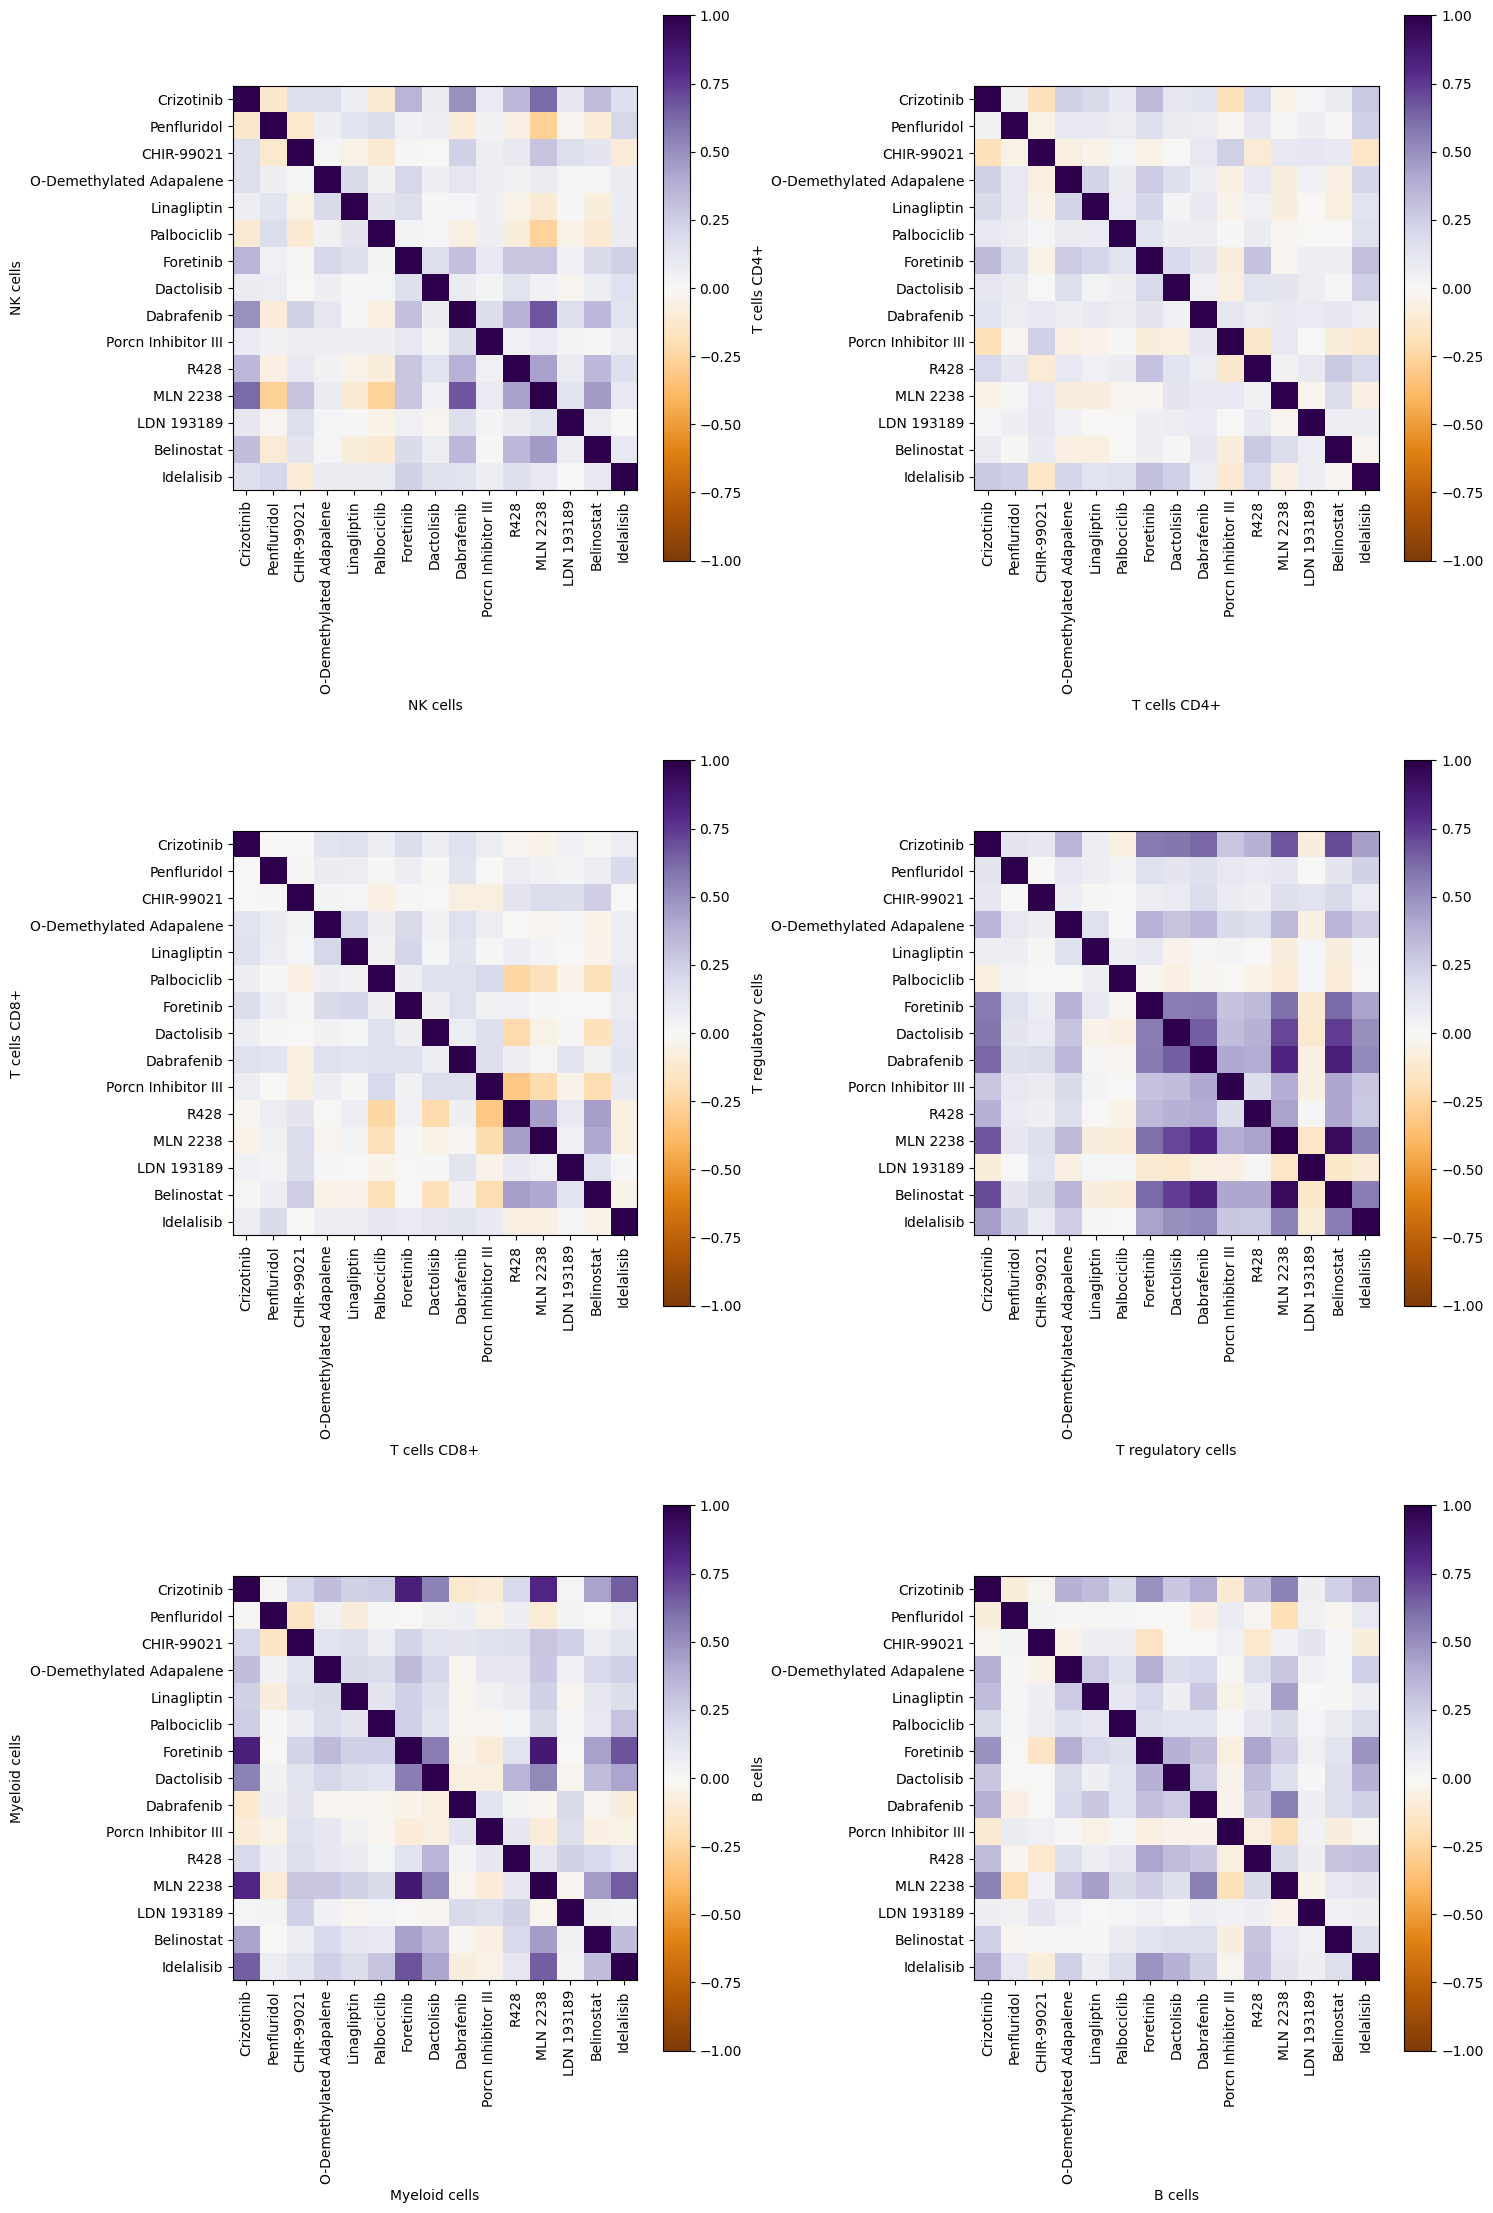

In [11]:
plt.figure(figsize=(15, 22.5))
for i, cell_type in enumerate(CELL_TYPES):
    plt.subplot(3, 2, i + 1)
    plot_comparison(cell_type, cell_type, list(train_sm_names))
plt.tight_layout()
plt.show()

It appears that some compounds induce very similar cell responses, and this can best be seen in T regulatory cells. In particular, Belinostat, Dabrafenib, Foretinib, MLN 2238, Crizotinib and Idelalisib all highly correlate between each other. Most of them are used in cancer treatment, and are meant for inhibiting protein kinases.

Let's now look at the correlations between each of the "training" cell type and B cells, to see how easily differential expression patterns can be extrapolated from the training data to B cells.

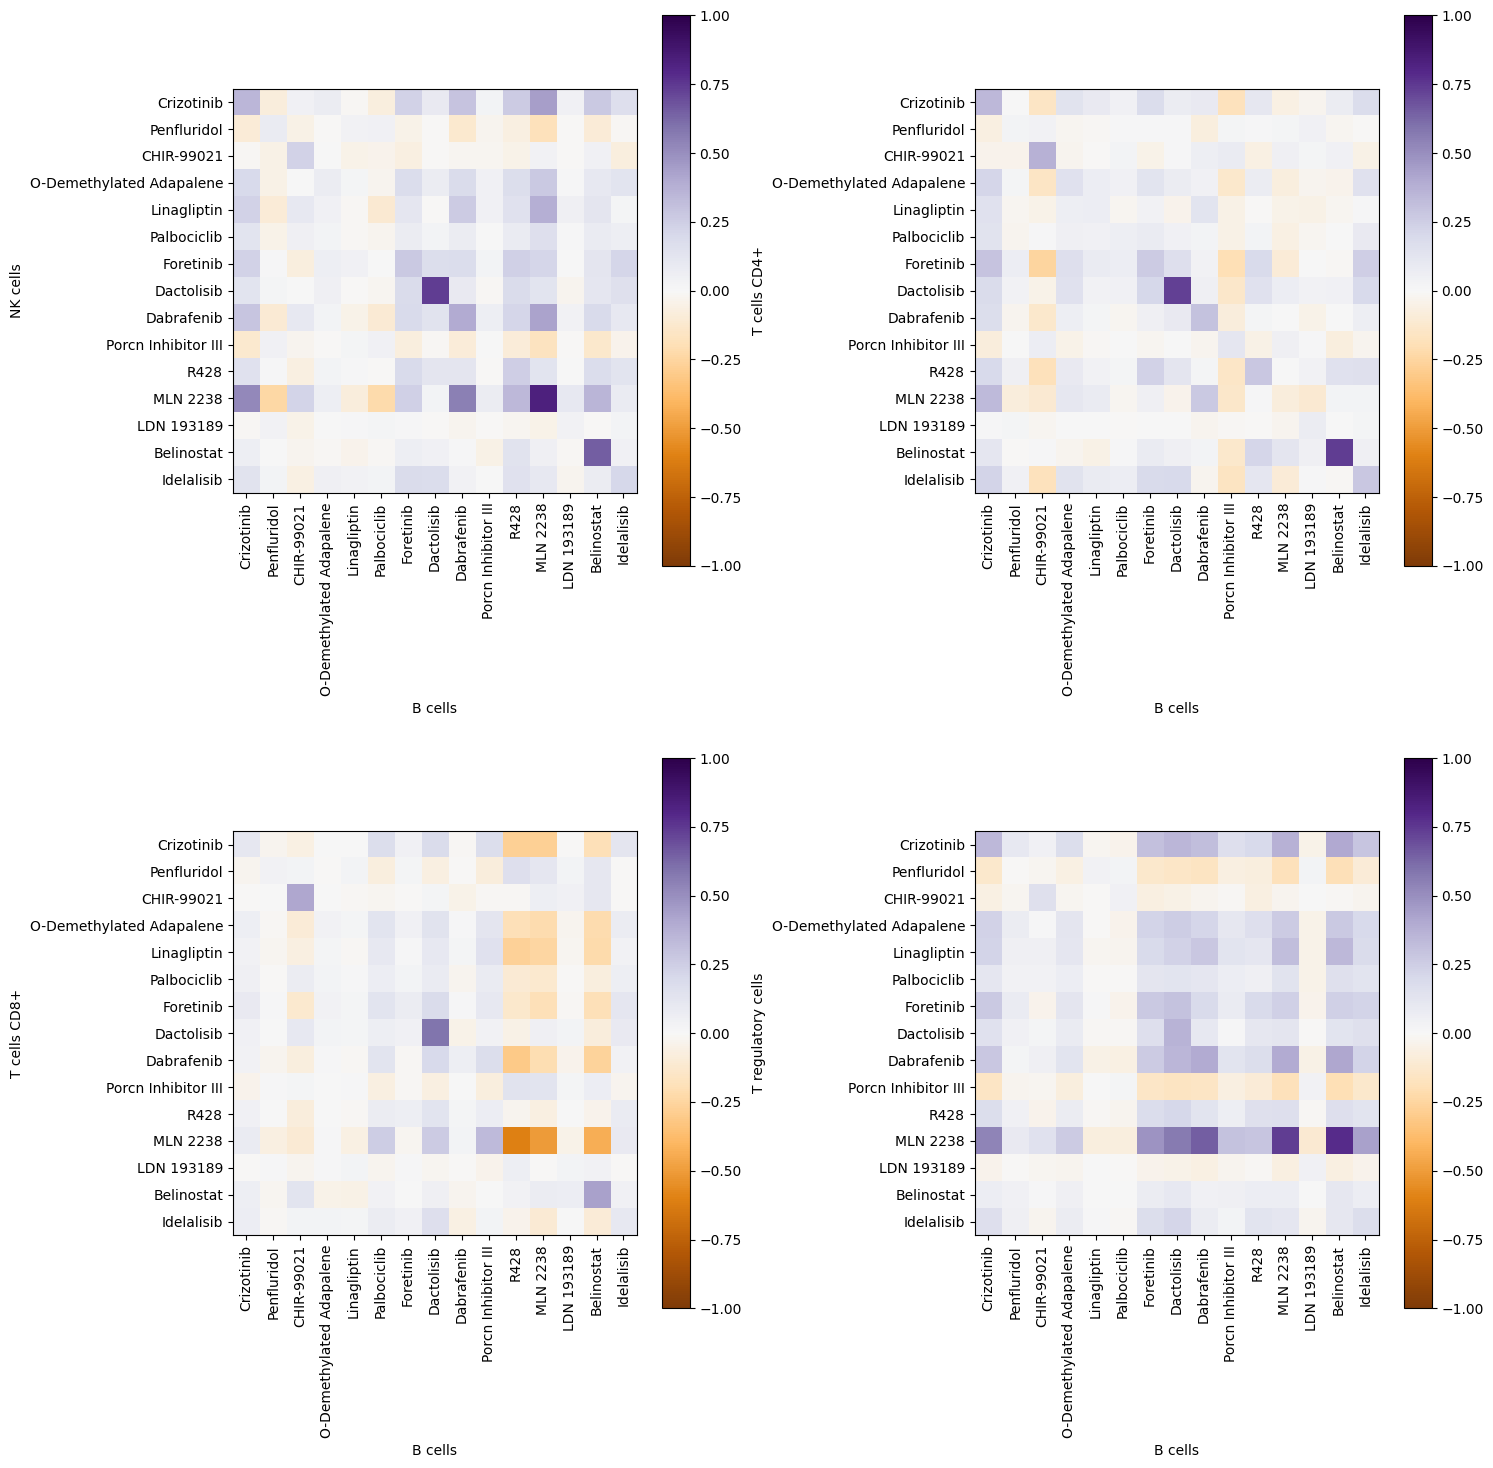

In [12]:
plt.figure(figsize=(15, 15))
for i, cell_type in enumerate(TRAIN_CELL_TYPES):
    plt.subplot(2, 2, i + 1)
    plot_comparison('B cells', cell_type, list(train_sm_names))
plt.tight_layout()
plt.show()

Based on the diagonals of these correlations matrices, we observe low preservation of the DE patterns across cell types. The only compounds that show consistently high values are Belinostat, Dactolisib and CHIR-99021. Surprisingly, we observe highly negative correlations in some compounds pairs between CD8+ T cells and B cells, especially for Belinostat, R428 and MLN 2238. Let's note that results for MLN 2238 might not be reliable due to the low cell counts used to estimate the DE values.

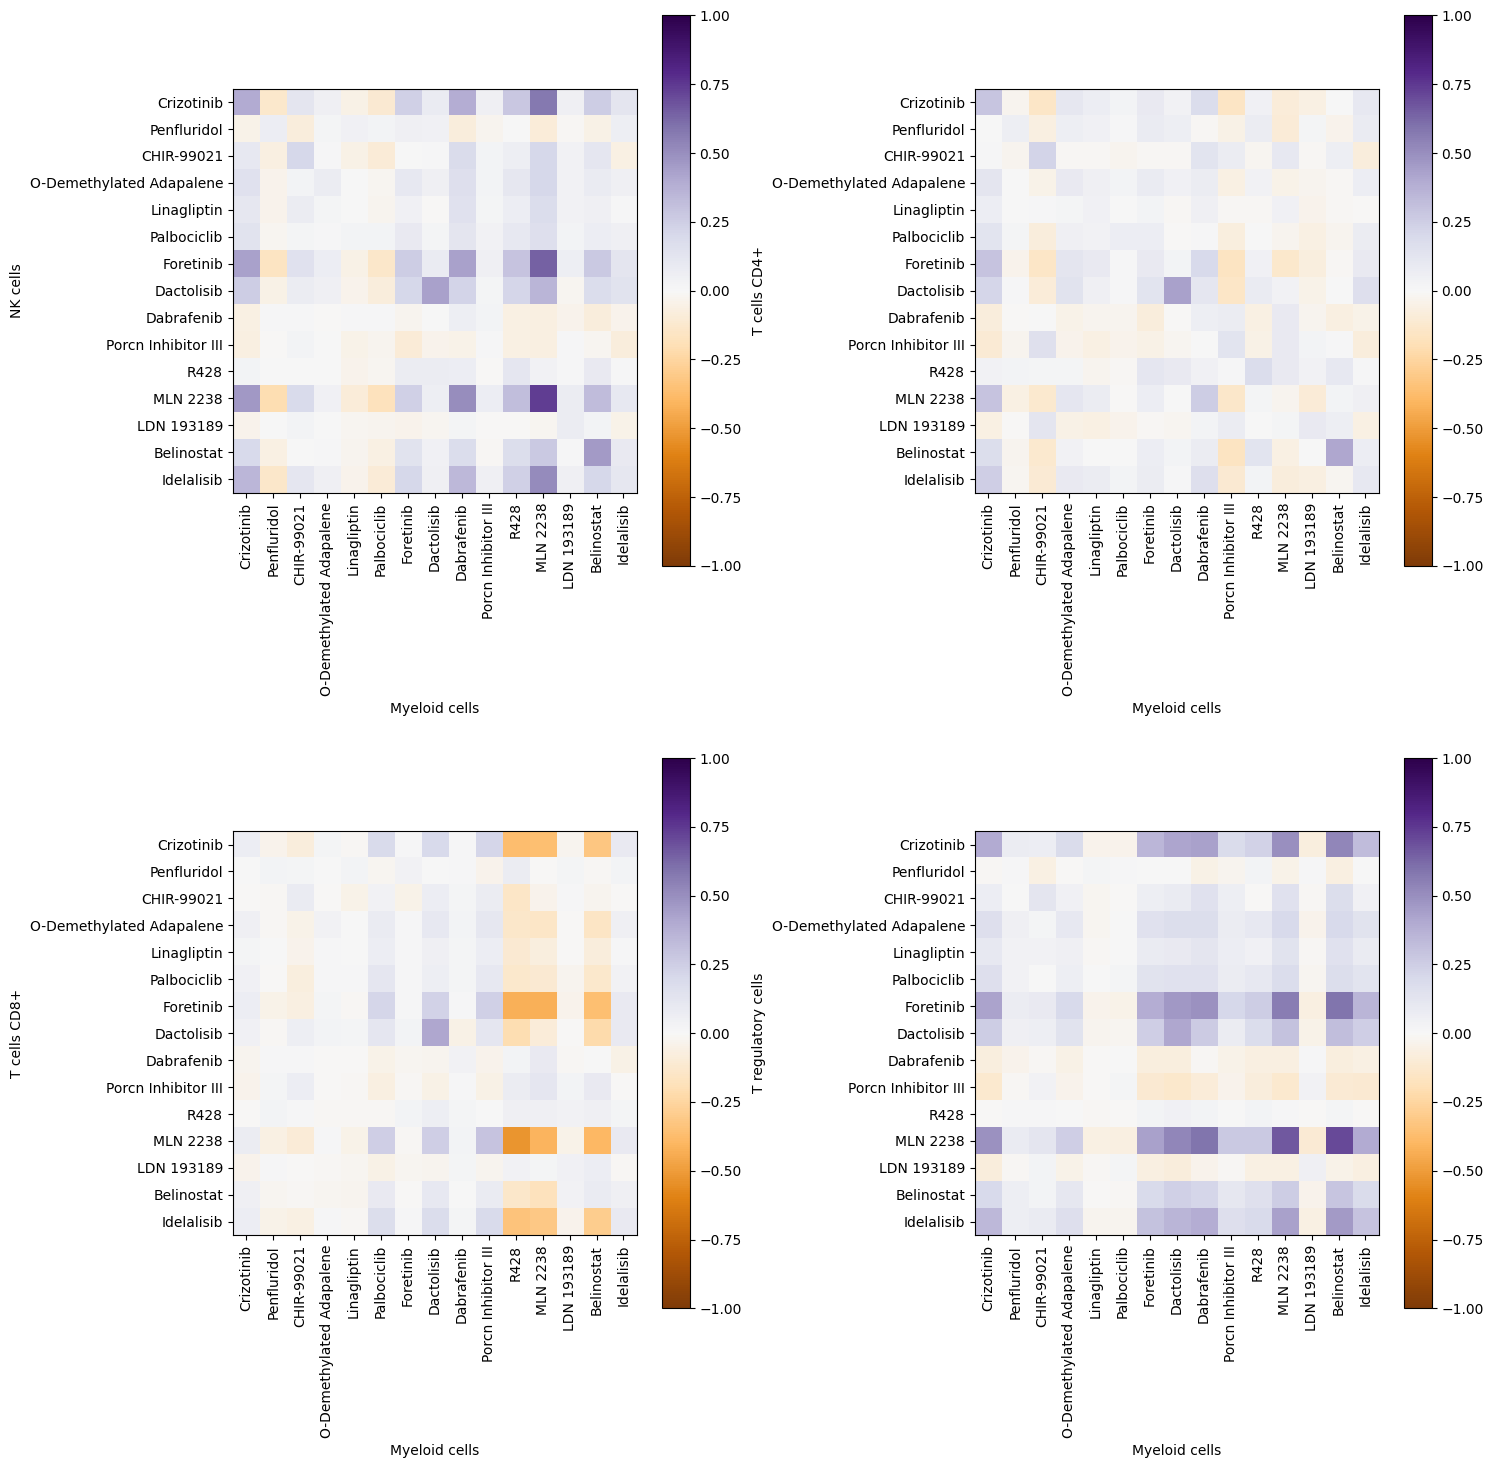

In [13]:
plt.figure(figsize=(15, 15))
for i, cell_type in enumerate(TRAIN_CELL_TYPES):
    plt.subplot(2, 2, i + 1)
    plot_comparison('Myeloid cells', cell_type, list(train_sm_names))
plt.tight_layout()
plt.show()

Similar patterns can be observed between the "training" cell types and myeloid cells.

<h2 id="housekeeping_genes">Differentially-expressed genes and housekeeping genes</h2> <a class="anchor" id="housekeeping_genes"></a>

Housekeeping genes are ubiquitously-expressed genes in charge of basic cellular functions. Due to their crucial role, they are expressed at near-constant levels. In principle, the DE values at our disposal should reflect this stability.
To verify this assumption, let's use the list of 3804 housekeeping genes found in the study of [Eisenberg and Levanon](#ref_housekeeping).

In [14]:
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = set(df.loc[:, 0])  # Gene names
print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

Number of housekeeping genes: 3804


Let $X$ be a random variable producing our DE values. Let $S$ be the dummy categorical variable giving the sign of $X$, and $P$ the p-value associated with a t-statistic. Based on the original [data description](#ref_kaggle), variable $X$ can be formalized as such:

$$
\begin{align}
&& X && = && - S \ \text{log}_{10}(P) \\
&& S && = && \text{sign}(X)
\end{align}
$$

Since $S = \text{sign}(X)$, the equality $X S = \left\vert X \right\vert$ holds:

$$
\begin{align}
&& \left\vert X \right\vert && = && -\text{log}_{10}(P) \\
\iff && P && = && 10^{-\left\vert X \right\vert } \\
\end{align}
$$

Now that we know how to compute the p-values from the DE values, it is easy to devise a statistical test to determine whether a gene is differentially-expressed (DE) or not. We simply apply a 1-sample Kolmogorov-Smirnov (KS) test on the p-values over all ``(cell_type, sm_name)`` pairs for a given gene, by comparing it with the cumulative density function of a uniform distribution.

Let's perform the test for each gene and derive a KS p-value for each of them.

In [15]:
de_p_values = []
for k in tqdm.tqdm(range(len(gene_names))):  # Perform test for each gene
    xs = 10 ** (-np.abs(data[:, k]))  # Transform DE values to p-values (assumed to be uniformly-distributed)
    res = scipy.stats.mstats.ks_1samp(xs, scipy.stats.uniform.cdf)  # Kolmogorov-Smirnov test
    de_p_values.append(res[1])
de_p_values = np.asarray(de_p_values)

significance_threshold = 0.001  # Arbitrary cutoff
significance_threshold /= len(gene_names)  # Bonferroni correction

100%|██████████| 18211/18211 [00:19<00:00, 946.60it/s]


In [16]:
# Mask to keep only housekeeping genes
hk_mask = np.asarray([gene_name in housekeeping_genes for gene_name in gene_names], dtype=bool)

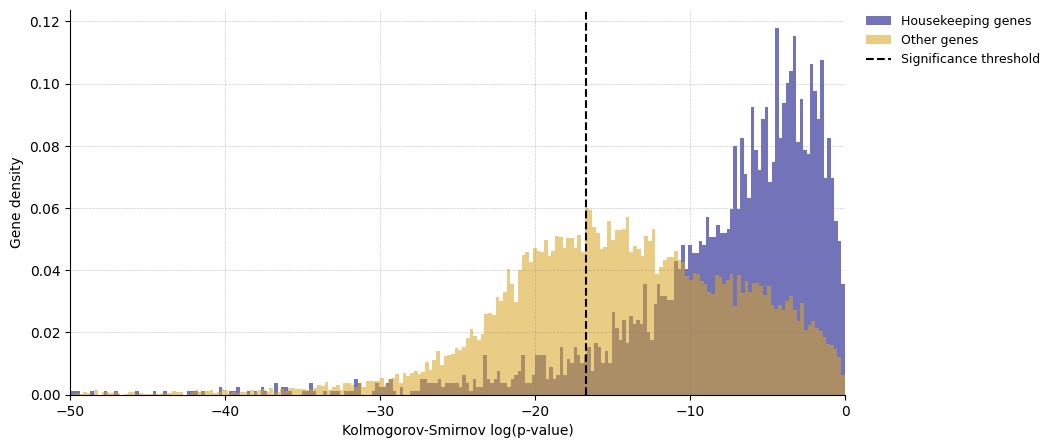

Proportion of differentially-expressed genes:
Housekeeping genes: 0.09607731665719159 (338 / 3518)
Other genes: 0.3824270060573062 (5619 / 14693)


In [17]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
plt.hist(np.log(de_p_values)[hk_mask], bins=1000, density=True, alpha=0.55, label='Housekeeping genes', color='navy')
plt.hist(np.log(de_p_values)[~hk_mask], bins=1000, density=True, alpha=0.55, label='Other genes', color='goldenrod')
plt.axvline(x=np.log(significance_threshold), linestyle='--', color='black', label='Significance threshold')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Kolmogorov-Smirnov log(p-value)')
plt.ylabel('Gene density')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.xlim([-50, 0])
plt.show()

print('Proportion of differentially-expressed genes:')
n_sig = np.sum(de_p_values[hk_mask] < significance_threshold)
print(f'Housekeeping genes: {n_sig / np.sum(hk_mask)} ({n_sig} / {np.sum(hk_mask)})')
n_sig = np.sum(de_p_values[~hk_mask] < significance_threshold)
print(f'Other genes: {n_sig / np.sum(~hk_mask)} ({n_sig} / {np.sum(~hk_mask)})')

Using a 1-sample Kolmogorov-Smirnov test on the DE values with a 0.001 significance threshold and Bonferroni correction, we identify 338 DE genes out of the original list of 3518 housekeeping genes. In conclusion, housekeeping genes have more stable expression levels compared to other genes, as only ~10% of them appear to be differentially-expressed, <span style="color:crimson;">4 times less</span> than for the other genes.

Let's look at the housekeeping gene with most DE:

In [18]:
gene_name = np.asarray(gene_names)[hk_mask][np.argmin(de_p_values[hk_mask])]
gene_name

'LDHA'

In [19]:
k = gene_name_dict['LDHA']
j = np.argmin(data[:, k])  # Index of the compound which inhibits LDHA the most
sm_names[j]  # Name of that compound

'Belinostat'

The [LDHA](#ref_ldha) gene encodes for the Lactate dehydrogenase A enzyme, which is known to have more elevated levels in hypoxic conditions as well as in cancer. LDHA catalyzes the conversion of pyruvate to lactate, enabling anaerobic glycosis and therefore ensuring energy supply in this hypoxic environment. [Belinostat](#ref_hypoxia), on the other hand, is known to inhibit hypoxia signalling and interfere with multiple hypoxia response pathways.

<h2 id="chemical_descriptors">Which chemical descriptors are actually useful?</h2> <a class="anchor" id="chemical_descriptors"></a>

One of the key challenges is the appropriate modeling of the compounds themselves, as it is crucial for good generalization to the test data. Indeed, while one-hot-encoding of the compounds is a simple and valid option, it remains very limited due to the inability to explicitly learn from the similarities between molecules. We tried many approaches for using the SMILES of the given compounds, including using Morgan fingerprints or embedding the molecules using large language models, but none of these methods proved to be fruitful.

Let's reproduce our prefered approach, which consists in first extracting chemical descriptors for each compound, using the ``rdkit`` library.

In [20]:
sm_desc = {}
for smiles, sm_name in tqdm.tqdm(list(zip(all_smiles, sm_names))):
    if sm_name not in sm_desc:  # Avoid doing the same computations twice
        molecule = Chem.MolFromSmiles(smiles)
        desc = Descriptors.CalcMolDescriptors(molecule)
        keys = list(sorted(desc.keys()))  # Ensure descriptors are consistently ordered
        values = np.asarray([desc[key] for key in keys], dtype=float)
        sm_desc[sm_name] = (desc, values)
sm_desc_arr = np.asarray([sm_desc[sm_name][1] for sm_name in unique_sm_names])

100%|██████████| 614/614 [00:03<00:00, 183.33it/s]


``rdkit`` extracts hundreds of descriptors, and we expect most of them to be uninformative with respect to the problem at hand. Therefore, irrelevant descriptors need to be filtered out. To quantify the relevance of a feature, we measure the Pearson correlation between each descriptor and the first kernel (RBF) principal component of the data. Indeed, we focus on the descriptors that are actually a source of variability in the data, to ensure some consistency between descriptor-based clustering and DE-based clustering.

In [21]:
threshold = 0.001  # Significance threshold
idx = set()

# We run the analysis for each cell type separately.
# We focus on the cell types for which all compounds are available,
# and therefore exclude CD8+ T cells as they contain a missing value.
for cell_type in ['NK cells', 'T cells CD4+', 'T regulatory cells']:
    X = np.asarray([data_dict[sm_name][cell_type] for sm_name in unique_sm_names])
    pc1 = np.squeeze(KernelPCA(n_components=1).fit_transform(X))
    for j in range(sm_desc_arr.shape[1]):
        
        # If descriptor is constant, then disregard it
        if np.all(sm_desc_arr[:, j] == sm_desc_arr[0, j]):
            continue
        
        # Compute Pearson correlation between descriptor and first PC
        res = scipy.stats.pearsonr(pc1, sm_desc_arr[:, j])
        if res[1] < threshold:
            print(j, keys[j], res)  # Show "significant" relationships
            idx.add(j)

67 NumHDonors (0.2866773211193256, 0.0004513386817806155)
117 VSA_EState3 (0.27528828545893913, 0.0007711443144493464)
137 fr_HOCCN (0.27298313322070944, 0.0008570990021033357)
142 fr_N_O (0.41980216172214113, 1.3301347860424886e-07)
200 fr_sulfonamd (0.3030843971344091, 0.00020036206609949948)
142 fr_N_O (0.3081456022568219, 0.00015443243625185569)


Most relevant descriptors are:

- NumHDonors: Number of Hydrogen Bond Donors
- VSA_EState3: VSA EState Descriptor 3 ( 5.00 <= x < 5.41)
- fr_N_O: Number of hydroxylamine groups
- fr_sulfonamd: Number of sulfonamides
- fr_HOCCN: Number of C(OH)CCN-Ctert-alkyl or C(OH)CCNcyclic

Explanations about VSA descriptors: https://greglandrum.github.io/rdkit-blog/posts/2023-04-17-what-are-the-vsa-descriptors.html

In [22]:
mask = np.asarray([sm_name in list(train_sm_names) for sm_name in unique_sm_names], dtype=bool)
for j in idx:
    train_frac = np.mean(sm_desc_arr[mask, j] > np.median(sm_desc_arr[mask, j]))
    test_frac = np.mean(sm_desc_arr[~mask, j] > np.median(sm_desc_arr[~mask, j]))
    print(f'DESCRIPTOR {j}:', train_frac, test_frac)
    print(set(sm_desc_arr[:, j]))
    print('')

DESCRIPTOR 67: 0.2 0.3053435114503817
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0}

DESCRIPTOR 200: 0.13333333333333333 0.04580152671755725
{0.0, 1.0}

DESCRIPTOR 137: 0.0 0.022900763358778626
{0.0, 1.0}

DESCRIPTOR 142: 0.06666666666666667 0.05343511450381679
{0.0, 1.0}

DESCRIPTOR 117: 0.4666666666666667 0.4961832061068702
{0.1950756547234378, 0.0, 2.9640846245905768, 3.0237962962962963, 3.5070127865961203, 3.8277437641723355, 5.70478149684159, 4.76576976828484, 8.607652143884419, 8.404079078106786, 8.87527893256068, 9.665943608159516, 9.216918601916753, 4.603362810657721, 14.712614260822685, 9.753357898715041, 16.250433424489962, 8.668680951051899, 18.39117777357857, 14.353066703919446, 20.33738552969799, 17.11806216451146, 22.025778567168757, 23.9518218694307, 21.762151340854963, 16.24512659009515, 20.439537824901226, 27.78961371247202, 28.02663595088871, 29.88394541467739, 30.413474926142953, 31.668515003942392, 32.78224420143489, 26.0040443504762, 34.694870559334845, 6.293713638195605, 28

In [23]:
idx = list(idx)
sm_desc_arr[:, 117] = (sm_desc_arr[:, 117] > np.median(sm_desc_arr[:, 117])).astype(int)  # Turning it to a binary varia
sm_desc_arr[sm_desc_arr[:, 67] > 4, 67] = 4  # Avoid having too many categories
idx.remove(137)  # Remove this descriptor due to low variance
selected_desc_names = [keys[j] for j in idx]  # Names of the chemical descriptors we considered
selected_desc_names

['NumHDonors', 'fr_sulfonamd', 'fr_N_O', 'VSA_EState3']

In [24]:
def descriptors_to_categories(desc: Dict[str, float]) -> List[str]:
    """Encode chemical descriptors as a list, that will be further used as
    a feature vector to train a ML model.
    
    Args:
        desc: Dict containing the descriptor names as keys and their values as dict values.
        
    Returns:
        Data in list format. Variables are ensured to be categorical.
    """
    values = []
    value = sm_desc[sm_name][0]['NumHDonors']
    if value > 4:
        value = 4  # Avoid having too many categories
    values.append(str(value))
    values.append(str(desc['fr_sulfonamd']))
    values.append(str(desc['fr_N_O']))
    values.append(str(desc['VSA_EState3'] > 12.0))  # Make the variable binary
    return values


sm_desc_map = {sm_name: i for i, sm_name in enumerate(unique_sm_names)}
extra_categories = []
for sm_name in sm_names:
    extra_categories.append(descriptors_to_categories(sm_desc[sm_name][0]))
extra_categories = np.asarray(extra_categories).T
# `extra_categories` is a matrix that contains extra input features
print(extra_categories)

[['0' '0' '0' ... '2' '2' '2']
 ['0' '0' '0' ... '0' '0' '0']
 ['0' '0' '0' ... '0' '0' '0']
 ['False' 'False' 'False' ... 'False' 'False' 'False']]


We noticed that target encoding of the features is very effective for modeling DE values, and among the approaches we experimented with, we tried to convert the selected chemical descriptors to categorical variables for compliance with the target encoder. However, neither target encoding of the chemical descriptors, compound embeddings or Morgan fingerprints did improve any of our cross-validation score or our public leaderboard score.

<h2 id="interpolation_vs_extrapolation">Interpolation vs Extrapolation</h2> <a class="anchor" id="interpolation_vs_extrapolation"></a>

Let ``C1``, ``C2`` be compounds, and ``T1``, ``T2`` be cell types. Let's assume DE values are known for combinations ``(T1, C1)``, ``(T1, C2)`` and ``(T2, C1)``, and they are absent from the training set for combination ``(T2, C2)``. Finally, let's denote by ``DE(T, C)`` the 18211-dimensional vector of DE values for pair ``(T, C)``.

To estimate ``DE(T2, C2)`` by linear interpolation using all the training data available, we simply average across all the samples originating from the same cell type or treated with the same compound. This is equivalent to taking the average of the cell type's target encoding and the compound's target encoding:

$$
\begin{align}
&& DE(T_2, C_2) && \simeq && \mathbb{E}_{(T_1 = T_2) \ \oplus \ (C_1 = C_2)} \left[ DE(T_1, C_1) \right] \\
\end{align}
$$

The xor operator $\oplus$ is used to ensure we don't leak the (cell type, compound) pair we are trying to estimate, to avoid any overoptimistic performance evaluation.

For our extrapolation strategy, we consider all ``(T1, C1)`` pairs which differ from ``(T2, C2)`` both by their cell type and compound to avoid any information leakage, and average across the differences in effects:

$$
\begin{align}
&& DE(T_2, C_2) && \simeq && \mathbb{E}_{(T_1 \neq T_2) \ \wedge \ (C_1 \neq C_2)} \left[ DE(T_2, C_1) + DE(T_1, C_2) - DE(T_1, C_1) \right] \\
\end{align}
$$

For both approaches, we average across all the valid pairs from the training set, as we have no means to know upfront what is the best way to interpolate or extrapolate from the data, and more specifically which samples to interpolate/extrapolate from. We therefore kept the approach simple as we are still in a data exploration phase.

In [25]:
def naive_method(method: str = 'extrapolate') -> np.ndarray:
    """Simple baseline method for predicting DE from the training data.
    
    Args:
        method: Method to use. Either "interpolate" or "extrapolate".
        
    Returns:
        A 18211-dimensional vector containing the coefficient of determination
            for the prediction of each gene's DE, using the chosen method.
    """
    pred = np.zeros_like(data)
    for i, (cell_type, sm_name) in enumerate(zip(cell_types, sm_names)):
        if method == 'interpolate':
            
            # Average DE values across all samples sharing the same cell type or compound,
            # but excluding the (cell type, compound) pair we attempt to estimate.
            mask = np.logical_xor(sm_names == sm_name, cell_types == cell_type)
            pred[i, :] = np.mean(data[mask, :], axis=0)
        else:
            
            # Average DE differences across all (T1, C1), (T2, C1), (T1, C2) triplets,
            # where the differences are of the form (T2, C1) + (T1, C2) - (T1, C1).
            # To avoid any data contamination, all three pairs should be different
            # from the (cell type, compound) pair we attempt to estimate.
            n_pairs = 0
            for t1 in unique_cell_types:
                for c1 in unique_sm_names:
                    if (t1 != cell_type) and (c1 != sm_name):
                        try:
                            pred[i, :] += data_dict[sm_name][t1] + data_dict[c1][cell_type] - data_dict[c1][t1]
                            n_pairs += 1
                        except KeyError:  # There are some missing data (typically, CD8+ T cells)
                            continue
            pred[i, :] /= n_pairs  # Normalization to turn the sum into an average
    
    # Per-gene sums of squared residuals
    ss_res = np.mean(np.square(data - pred), axis=0)
    
    # Per-gene standard deviations
    ss_tot = np.mean(np.square(data - np.mean(data, axis=0)[np.newaxis, :]), axis=0)
    
    # Per-gene coefficients of determination
    return 1. - ss_res / ss_tot


r2_inter = naive_method(method='interpolate')
r2_extra = naive_method(method='extrapolate')

In the figure below, we reported the coefficient of determination (r²) for the prediction of each gene's DE, using the interpolation (x-axis) and the extrapolation (y-axis) methods.

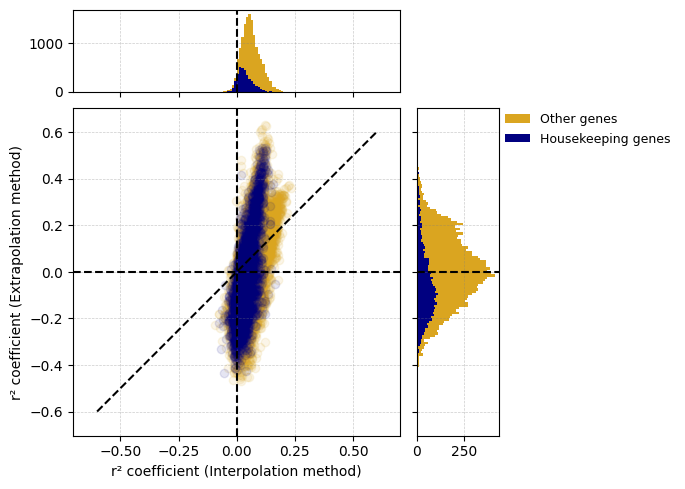

In [26]:
xs = r2_inter
ys = r2_extra
fig = plt.figure(layout='constrained')
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax.scatter(xs[~hk_mask], ys[~hk_mask], alpha=0.1, color='goldenrod')
ax.scatter(xs[hk_mask], ys[hk_mask], alpha=0.1, color='navy')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.plot([-0.6, 0.6], [-0.6, 0.6], color='black', linestyle='--')
ax.axvline(x=0, linestyle='--', color='black')
ax.axhline(y=0, linestyle='--', color='black')
ax.set_xlabel('r² coefficient (Interpolation method)')
ax.set_ylabel('r² coefficient (Extrapolation method)')
binwidth = 0.01
xymax = max(np.max(np.abs(xs)), np.max(np.abs(ys)))
lim = (int(xymax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(xs[~hk_mask], bins=bins, color='goldenrod', label='Other genes')
ax_histx.hist(xs[hk_mask], bins=bins, color='navy', label='Housekeeping genes')
ax_histx.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax_histx.axvline(x=0, linestyle='--', color='black')
ax_histy.hist(ys[~hk_mask], bins=bins, orientation='horizontal', color='goldenrod', label='Other genes')
ax_histy.hist(ys[hk_mask], bins=bins, orientation='horizontal', color='navy', label='Housekeeping genes')
ax_histy.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'family': 'Century gothic', 'size': 9}
ax_histy.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
ax_histy.axhline(y=0, linestyle='--', color='black')
plt.show()

While interpolation performs better than random for the overwhelming majority of the genes, r² scores all remain very low (< 0.25). While extrapolation offers the possibility to reach r² scores higher than 0.6 for some genes, it can also overfit and produce highly negative r². Notably, on average <span style="color:crimson;">extrapolation produces worse performance on housekeeping genes</span> compared to the other genes. However, the right side histogram shows a second mode at r²=0.2 (in yellow), showing that extrapolation is a promising approach for a certain category of gene. Since these genes are not housekeeping genes, it appears that performance is strongly driven by the fact a gene is actually DE or not.

To confirm this, we show the relationship between the performance of the extrapolation method versus the p-values computed earlier to assess whether genes are actually DE or not:

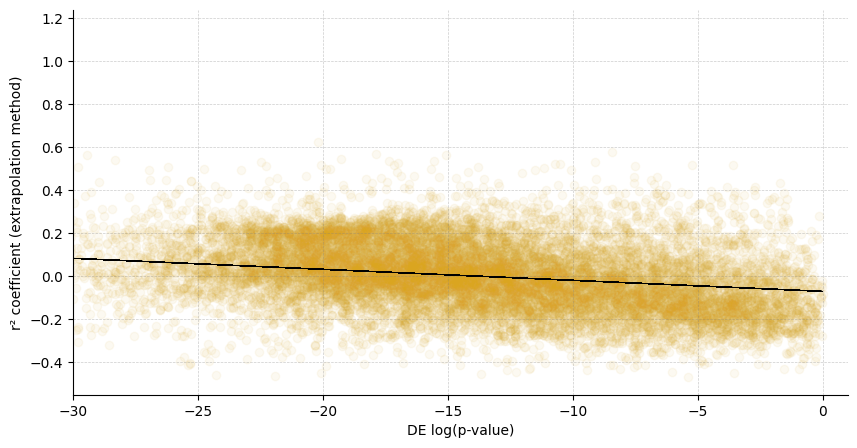

Spearman correlation: SpearmanrResult(correlation=-0.3734678004002386, pvalue=0.0)


In [27]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
xs = np.log(de_p_values[~hk_mask])  # DE p-values for non-housekeeping genes
ys = r2_extra[~hk_mask]  # r2 coefficients for the estimation of these genes
b, a = np.polyfit(xs, ys, deg=1)
plt.scatter(xs, ys, alpha=0.06, color='goldenrod')
plt.xlim([-30, 1])
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
plt.plot(xs, a + b * xs, color='black', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('DE log(p-value)')
plt.ylabel('r² coefficient (extrapolation method)')
plt.show()
print(f'Spearman correlation: {scipy.stats.spearmanr(xs, ys)}')

We conclude that indeed, the more significant differential expression is for a particular gene, the more easily it can be estimated.

However, when a gene is not DE (as is the case for housekeeping genes notably), it is safer to not extrapolate from the data too much, as gene expression in unseen samples might be very similar to what can be observed in the training data. Therefore, it is advisable to build a model that accounts for the DE significance, for example by applying stronger regularization on housekeeping genes, and alleviating this regularization on genes which are known to be differentially-expressed. However, due to time constraints we did not experiment with this idea ourselves.

<h1 id="model-design">Model design</h1> <a class="anchor" id="model-design"></a>

<h2 id="encoding-categories">Encoding the categories</h2> <a class="anchor" id="encoding-categories"></a>

We noticed that target encoding of cell types and compounds noticeably helps, compared to one-hot-encoding. Also, we regrettably noticed that adding extra features to these encodings, such as chemical descriptors or NN-based embeddings, systematically decreased cross-validation and LB scores.

The idea is to perform the target encoding of the cell type and compound with respect to <span style="color:crimson;">each</span> gene, thus producing $2 \times 18211$-dimensional vectors. However, encoders from the ``category_encoders`` Python library cannot handle multi-output datasets. Let's extend their implementation to account for the myriad of genes present in the data. We will target-encode both the compound and the cell type with respect to each of the gene, thus producing a tensor a shape ``(n, n_genes, 2)``.

In [28]:
class MultiOutputTargetEncoder:
    """Multi-output target encoder.
    
    Each input (categorical) feature will be encoded based on each (continuous) output variable.
    
    Attributes:
        encoders: List of encoders, of shape `n_genes`.
    """
    
    def __init__(self):
        self.encoders: List[category_encoders.leave_one_out.LeaveOneOutEncoder] = []
        
    @staticmethod
    def new_encoder() -> category_encoders.leave_one_out.LeaveOneOutEncoder:
        """Instantiates a new gene-specific target encoder.
        
        Returns:
            New instance of a target encoder.
        """
        return category_encoders.leave_one_out.LeaveOneOutEncoder(return_df=False)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Fit the encoders for each input feature and output variable.
        
        Args:
            X: Array of shape `(n, n_features)` containing categories as strings or integers.
                Typical, `n_features` is equal to 2 (cell type + compound).
            y: Array of shape `(n, n_genes)` containing the DE values for all the genes.
        """
        self.encoders = []
        for j in tqdm.tqdm(range(y.shape[1]), desc='fit LOO encoders'):
            self.encoders.append(MultiOutputTargetEncoder.new_encoder())
            self.encoders[-1].fit(X, y[:, j])
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """Encodes the categories. Assumes the encoders have already been fitted.
        
        Args:
            X: Array of shape `(n, n_features)` containing categories as strings or integers.
        
        Returns:
            Array of shape `(n, n_genes, n_features)` containing the encoding of each input
                feature with respect to each output variable.
        """
        Z = []
        for encoder in tqdm.tqdm(self.encoders, desc='transform LOO encoders'):
            y_hat = encoder.transform(X)
            Z.append(y_hat)
        Z = np.asarray(Z)
        return np.transpose(Z, (1, 0, 2))

Let's learn the target encodings from the data first.

In [29]:
encoder = MultiOutputTargetEncoder()
encoder.fit(np.asarray([cell_types, sm_names]).T, data)

fit LOO encoders: 100%|██████████| 18211/18211 [03:19<00:00, 91.28it/s]


We now transform the data in a second stage. The reason why we did not implement a ``fit_transform`` method to both fit and transform the data simultaneously, using the ``fit_transform`` method from ``category_encoders``, is that we noticed a drastic performance loss when using the leave-one-out procedure from the ``LeaveOneOutEncoder`` class. Indeed, the ``transform`` method does not apply this procedure. The reason for not using the ``TargetEncoder`` class instead is because we did not want to use the smoothing approach, which also decreases performance.

In [30]:
X = torch.FloatTensor(encoder.transform(np.asarray([cell_types, sm_names]).T))
if USE_GPU:
    X = X.cuda()

transform LOO encoders: 100%|██████████| 18211/18211 [01:29<00:00, 203.49it/s]


<h2 id="biological-networks">Integration of prior knowledge in the form of biological networks</h2> <a class="anchor" id="biological-networks"></a>

Our model will take tensors of shape ``(batch_size, n_genes, 2)`` as input and produce DE estimates of shape ``(batch_size, n_genes)``. A first option to handle this high dimensionality is to build a multi-layer perceptron with small number of hidden nodes: all genes are connected to hidden nodes, which are in turn connect to all genes. Another option is to connect the genes in a more informed manner, by connecting genes to genes based on prior knowledge.

<h3 id="biological-network-pathways">Gene - Pathways</h3> <a class="anchor" id="biological-network-pathways"></a>

One way to identify genes which are predictive for each other, is by looking at genes involved in the same pathways. We fetched this information from gene set C2 (CP: Canonical pathways) available at https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp. We prealably downloaded this file and reformatted it as a JSON file, where keys are pathway names and values are lists of gene names. These connections between genes and pathways form a bipartite graph.

In [31]:
with open('/kaggle/input/op2-extra/canonical_pathways.json', 'r') as f:
    json_data = json.load(f)
pathway_idx = []
for i, key in tqdm.tqdm(enumerate(json_data.keys()), desc='Building pathways'):
    for gene_name in json_data[key]:
        if gene_name in gene_name_dict:  # Only if gene name is found in training data
            j = gene_name_dict[gene_name]
            pathway_idx.append([i, j])

# Array of shape (n_edges, 2) representing the edges of the graph.
# The graph is a bipartite graph where the 2 partitions correspond to genes and pathways, respectively.
pathway_idx = np.asarray(pathway_idx, dtype=int)
n_pathways = len(json_data)
print(len(pathway_idx))

Building pathways: 3795it [00:00, 44228.47it/s]

126021


Below we show the distributions of in- and out-degrees of nodes in this bipartite graph. While most pathways involved only few genes, one of them involved almost 1200 genes. Similarly, most genes are involved in few pathways, but one of the genes is part of almost 500 of them.

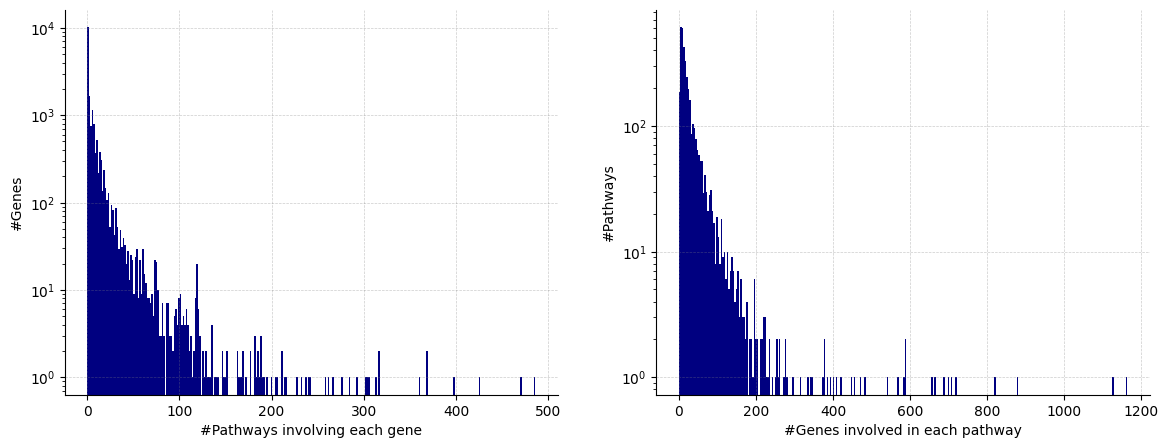

In [32]:
pathway_network = np.zeros((n_pathways, len(gene_names)))
pathway_network[pathway_idx[:, 0], pathway_idx[:, 1]] = 1
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.hist(pathway_network.sum(axis=0), bins=300, color='navy')
plt.xlabel('#Pathways involving each gene')
plt.ylabel('#Genes')
plt.yscale('log')
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['right', 'top']].set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.hist(pathway_network.sum(axis=1), bins=300, color='navy')
plt.xlabel('#Genes involved in each pathway')
plt.ylabel('#Pathways')
plt.yscale('log')
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['right', 'top']].set_visible(False)
plt.show()

<h3 id="biological-networks-grn">Gene Regulatory Network</h3> <a class="anchor" id="biological-networks-grn"></a>

A complementary way to predict the expression (or DE) of a gene is via its regulators. We fetched this information from gene set C3 (C3: regulatory target gene sets) available at https://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp. We prealably downloaded this file and reformatted it as a JSON file, where keys are regulator names and values are lists of gene names. These connections between genes and pathways form a bipartite graph.

In [33]:
with open('/kaggle/input/op2-extra/regulatory_target.json', 'r') as f:
    json_data = json.load(f)
regulator_map = {key: i for i, key in enumerate(list(json_data.keys()))}
grn_idx = []
for regulator_name in tqdm.tqdm(json_data.keys(), desc='Building GRN'):
    i = regulator_map[regulator_name]
    for gene_name in json_data[regulator_name]:
        if gene_name in gene_name_dict:  # Only if gene name is found in training data
            j = gene_name_dict[gene_name]
            if i != j:
                grn_idx.append([i, j])

# Array of shape (n_edges, 2) representing the edges of the graph.
# The graph is a bipartite graph where the 2 partitions correspond to target genes and regulators, respectively.
grn_idx = np.asarray(grn_idx, dtype=int)
n_regulators = len(json_data)
print(len(grn_idx))

Building GRN: 100%|██████████| 3713/3713 [00:01<00:00, 2627.27it/s] 

612830


Similarly to what we did for the gene-pathway network, we show below the distributions of in- and out-degrees. Similar observations can be done.

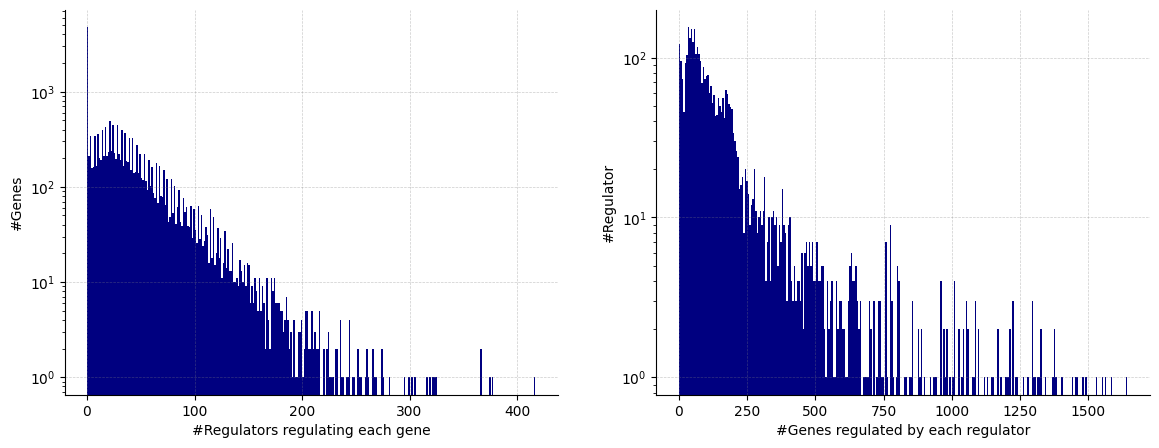

In [34]:
grn_network = np.zeros((n_regulators, len(gene_names)))
grn_network[grn_idx[:, 0], grn_idx[:, 1]] = 1
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.hist(grn_network.sum(axis=0), bins=300, color='navy')
plt.xlabel('#Regulators regulating each gene')
plt.ylabel('#Genes')
plt.yscale('log')
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['right', 'top']].set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.hist(grn_network.sum(axis=1), bins=300, color='navy')
plt.xlabel('#Genes regulated by each regulator')
plt.ylabel('#Regulator')
plt.yscale('log')
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['right', 'top']].set_visible(False)
plt.show()

<h3 id="biological-network-coaccessibility">Coaccessibility network</h3> <a class="anchor" id="biological-network-coaccessibility"></a>

Finally, my teammate [Jalil Nourisa](https://www.kaggle.com/jalilnourisa) inferred co-accessibility networks from the <span style="color:crimson;">ATAQ-seq data</span> provided by the organizers. More details about it can be found in his notebook. He inferred one network per cell type. Conceptually, it is possible to use a different graph per input sample and adapt the model to the specificities of each cell type. However, dynamic graph topology is not really compatible with mini-batching and drastically reduces computational speed. Therefore, here we build only one co-accessibility network, defined as the union of the edges found in the cell type-specific networks.

In [35]:
coacc_idx = set()
for cell_type in CELL_TYPES:  # Edges for our network are the union of the edges found in all cell types
    df = pd.read_csv(f'/kaggle/input/op2-extra/donor_0_{cell_type.replace("+", "")}.csv', header='infer')
    for gene1, gene2 in zip(df['gene1'], df['gene2']):
        i = gene_name_dict[gene1]  # Index of first gene
        j = gene_name_dict[gene2]  # Index of second gene
        if i != j:  # Assume a gene is not regulating itself
            coacc_idx.add((i, j))
            coacc_idx.add((j, i))  # If gene `i` is predictive for gene `j`, then the inverse is true as well
coacc_idx = np.asarray(list(coacc_idx), dtype=int)
print(len(coacc_idx))

128294


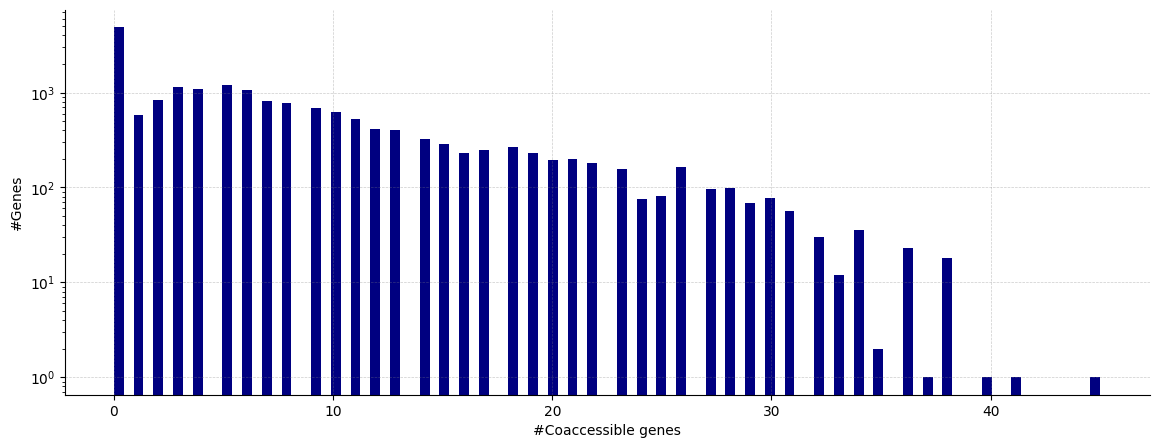

In [36]:
coacc_network = np.zeros((len(gene_names), len(gene_names)))
coacc_network[coacc_idx[:, 0], coacc_idx[:, 1]] = 1
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 1, 1)
plt.hist(coacc_network.sum(axis=0), bins=100, color='navy')
plt.xlabel('#Coaccessible genes')
plt.ylabel('#Genes')
plt.yscale('log')
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['right', 'top']].set_visible(False)
plt.show()

<h3 id="bms-layer">Biologically-Meaningul Sparsified Linear Layer</h3> <a class="anchor" id="bms-layer"></a>

There are countless ways to use biological networks within a Machine Learning model. One option is to derive gene embeddings that will later be used to model DE while accounting for the peculiarities of each gene. However, biological networks are not exhaustive due to the lack of experimental evidence and the difficulty to map biological entities to gene names. Therefore, we fear that gene embeddings learned from these sparse networks would just <span style="color:crimson;">mirror the in- and out-degrees of each gene in these graphs</span>.

Alternatively, we propose to integrate biological knowledge in the neural architecture itself, by defining sparsely-connected linear layers, with sparsity patterns defined by the biological networks, as proposed by [Verplaetse et al](#ref_ibd). Let's call these linear layers Biologically-meaningful sparsified, or BMS layers for short.

By design, our NN should output DE predictions for all genes. Let's assume that both the input and output dimensions are `n_genes`. Conceptually, the layers should be of size `(n_genes, n_genes)`. However, each biological network is not necessarily of the form `(n_genes, n_genes)`. We bypass this problem by using multiple BMS layers per network, when relevant:
- For the pathway-gene network, we use 2 BMS layers: `(n_genes, n_pathways)` and `(n_pathways, n_genes)`.
- Similarly for the gene regulatory network, we use 2 BMS layers: `(n_genes, n_regulators)` and `(n_regulators, n_genes)`.
- For the coaccessibility network, only 1 layer of shape `(n_genes, n_genes)` is needed, but we use 2 of them for consistency with the other networks.

In [37]:
class BMSparseLinear(torch.nn.Module):
    """Biologically-meaningful sparsified linear layer.
    
    Sparse linear layer, where the sparsity pattern is defined by a biological network.
    
    Attributes:
        n: Number of rows in the sparse weight matrix.
        m: Number of columns in the sparse weight matrix.
        weight: Sparse weight matrix, stored as a 1-dimensional tensor of shape `(n_edges,)`.
        index: Indices of the non-zero elements in the sparse matrix, of shape `(2, n_edges)`.
        bias: dense bias term of shape `(m,)`.
    """
    
    def __init__(self, n: int, m: int, edge_idx: torch.LongTensor, bias: bool = False):
        torch.nn.Module.__init__(self)
        self.n: int = n  # Number of rows in parameter matrix
        self.m: int = m  # Number of columns in parameter matrix
        self.weight: torch.Tensor = torch.nn.Parameter(torch.randn(len(edge_idx)))
        self.index = edge_idx.t()
        
        # Xavier-like uniform initialization
        u = np.sqrt(6 / min(self.m, self.n)) * 0.01
        self.weight.data.uniform_(-u, u)
        
        # Initialize bias term
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(self.m))
        else:
            self.bias = None
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Applies a sparse linear transformation on the inputs.
        
        Args:
            X: Input data of shape `(batch_size, self.n)`.
        
        Returns:
            Transformed data of shape `(batch_size, self.m)`.
        """
        index = self.index[[1, 0], :]
        weight = self.weight
        if X.is_cuda:
            index = index.cuda()
            weight = weight.cuda()
        
        # Create sparse tensor on-the-fly. This is the only way to make the parameters
        # differentiable in PyTorch without having recourse to lots of external dependencies.
        # Storing the sparse tensor as layer attribute does not work, as it produces sparse
        # gradients. Sparse gradients pose many issues, such as the non-compliance with
        # the Adam optimizer. This is a very easy work-around to avoid dealing with all
        # these inconveniences.
        A = torch.sparse_coo_tensor(index, weight, [self.m, self.n])
        
        # Sparse linear transformation
        X = torch.sparse.mm(A, X.t()).t()
        
        # Add bias term
        if self.bias is not None:
            X = X + self.bias.unsqueeze(0)
        
        return X

<h2 id="regularization">Regularization</h2> <a class="anchor" id="regularization"></a>

Under the null hypothesis (and some other conditions), p-values are [uniformly distributed](#ref_pvalues) random variables. Since DE values are defined as ``-sign(T)*log10(p-value)``, where ``T`` is the t-statistic, this means that many DE values, if not most of them <span style="color:crimson;">will deviate from 0 just by random chance.</span>

In order to prevent our models to learn irrelevant associations from background noise, we need to immunize them against it. Since background noise follows the null distribution, and since t-statistics are equally likely to be positive or negative under the null hypothesis, random sampling is trivial. ``sign(T)`` has 50% chance of being 1 and 50% of being 0. We randomly and uniformly sample ``p-value`` from the ``[cutoff, 1]`` interval, where ``cutoff`` is an arbitrarily small significance cutoff. Indeed, we do not consider tiny values to avoid introducing large values that may lead to numerical issues. This significance cutoff has no actual meaning and ``p-value`` should theoretically be sampled from the ``[0, 1]`` interval

In [38]:
def background_noise(
        *size: int,
        cutoff: float = 0.001,
        device: str = 'cpu',
        generator: torch.Generator = None
) -> torch.Tensor:
    """Generates random DE values under the null hypothesis.
    
    In the absence of any biological signal, p-values can be expected to be 
    uniformly distributed. Also, positive and negative DE values are equally likely.
    
    Args:
        size: shape of the output tensor.
        cutoff: Significance threshold used to make sure we don't introduce huge outliers in the data.
            This cutoff does not have a real statistical meaning, and is only meant for numerical stability.
            P-values will be randomly and uniformly sampled from the ``[cutoff, 1]`` interval.
        device: Device where to do the computations (cpu or gpu).
        generator: RNG used for sampling.
    
    Returns:
        Random DE values, stored in a tensor of the desired shape.
    """
    sign = 2 * torch.randint(0, 2, size, device=device) - 1
    return sign * torch.log10(cutoff + torch.rand(*size, device=device) * (1. - cutoff))

As can be observed in the figure below, the background noise distribution is very close to the actual distribution of training data, <span style="color:crimson;">which strongly suggests that most of the DE values are indeed random</span>.

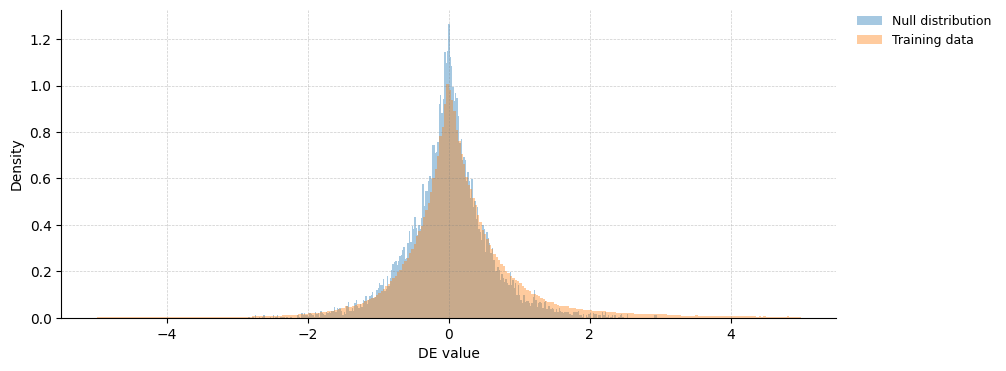

KstestResult(statistic=0.07931638629891602, pvalue=4.056301806242518e-55)

In [39]:
plt.figure(figsize=(10, 4))
xs = background_noise(10000).cpu().data.numpy()
ax = plt.subplot(1, 1, 1)
plt.hist(xs, bins=300, alpha=0.4, density=True, label='Null distribution')
ys = data.flatten()
ys = ys[np.abs(ys) < 5]  # Clipping for visibility purposes
plt.hist(ys, bins=300, alpha=0.4, density=True, label='Training data')
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('DE value')
plt.ylabel('Density')
ax.spines[['right', 'top']].set_visible(False)
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()

scipy.stats.ks_2samp(xs, ys)

Our model will be regularized by adding random values drawn from the null distribution to the ground-truth DE values.

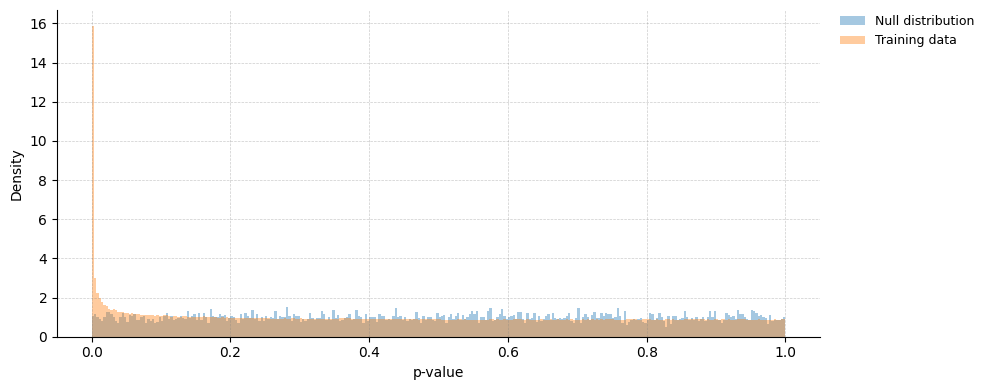

KstestResult(statistic=0.09192642189091071, pvalue=6.366216330527576e-74)

In [40]:
plt.figure(figsize=(10, 4))
xs = np.random.rand(10000)
ax = plt.subplot(1, 1, 1)
plt.hist(xs, bins=300, alpha=0.4, density=True, label='Null distribution')
ys = 10 ** (-np.abs(data.flatten()))
plt.hist(ys, bins=300, alpha=0.4, density=True, label='Training data')
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('p-value')
plt.ylabel('Density')
ax.spines[['right', 'top']].set_visible(False)
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('null-p-values.png', dpi=200)
plt.show()

scipy.stats.ks_2samp(xs, ys)

0.0703936143401892
0.04143216586889443


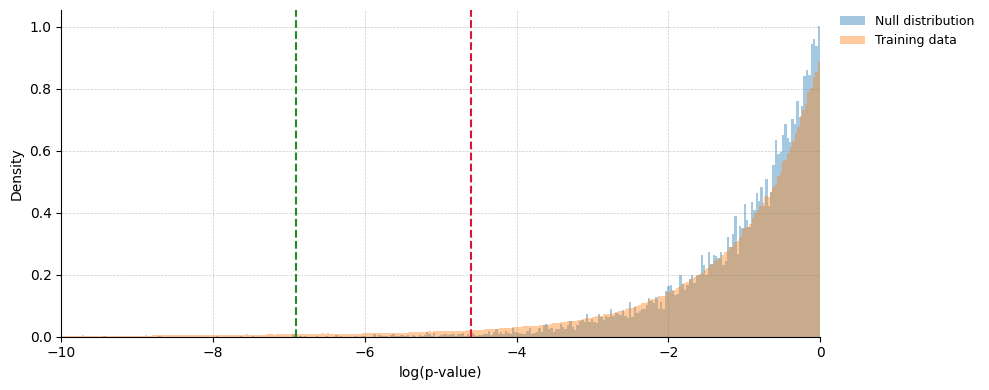

KstestResult(statistic=0.06915072681056583, pvalue=5.504135853124702e-42)

In [41]:
lb = -10
plt.figure(figsize=(10, 4))
xs = np.log(np.random.rand(10000))
ax = plt.subplot(1, 1, 1)
plt.hist(xs, bins=300, alpha=0.4, density=True, label='Null distribution')
ys = np.log(10 ** (-np.abs(data.flatten())))
print(np.mean(ys < np.log(0.01)))
print(np.mean(ys < np.log(0.001)))
ys = ys[ys > lb]  # For visibility purposes
plt.hist(ys, bins=300, alpha=0.4, density=True, label='Training data')
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
plt.xlim([lb, 0])
plt.axvline(x=np.log(0.01), linestyle='--', color='crimson')
plt.axvline(x=np.log(0.001), linestyle='--', color='forestgreen')
plt.xlabel('log(p-value)')
plt.ylabel('Density')
ax.spines[['right', 'top']].set_visible(False)
prop = {'family': 'Century gothic', 'size': 9}
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('null-log-p-values.png', dpi=200)
plt.show()

scipy.stats.ks_2samp(xs, ys)

<h2 id="neural-architecture">Neural architecture</h2> <a class="anchor" id="neural-architecture"></a>

We illustrate below the complete architecture of our neural network. The number of genes (=18211) is denoted by $g$. The input vector, of shape $2g$ (each gene has been target-encoded toward both cell type and compound), is reduced to a latent vector of very small size (=16) which is further refined by a small MLP, and finally mapped back to the original $2g$ dimension (the number of output channels is arbitrary, e.g., $g$ is a valid choice as well). We call this first MLP <span style="color:crimson;">sample-centric</span>.

Because this first module introduces an information bottleneck, we process the original input features, as well as the output of the first module with a second MLP. This time, genes are treated as separate observations, therefore avoiding any dimensionality reduction. Of course, this approach assumes that a part of the predictive mechanism is gene-agnostic, and that all the gene-specific computations have already been carried on by the sample-centric MLP. This MLP, which we coined <span style="color:crimson;">gene-centric</span> MLP, helps refining the predictions made by the sample-centric MLP without any information loss, and using a very limited number of parameters, thus preventing any overfitting risk. Indeed, in the worst case scenario, this MLP will just learn the identity function.

Finally, as an optional step, we further refine the predictions using a sparse MLP (made of <span style="color:crimson;">BMS layers</span>), with sparsity patterns pre-defined by the biological networks we just created. The motivation behind this is the little room left for learning gene-specific knowledge, due to (1) the small latent space in the sample-centric MLP, and (2) the fact that the gene-centric MLP treats genes as interchangeable observations.

![](https://raw.githubusercontent.com/AntoinePassemiers/Open-Challenges-Single-Cell-Perturbations/master/docs/OP2-Architecture.png)

In [42]:
class NN(torch.nn.Module):
    """Deep learning architecture composed of 2 modules: a sample-centric MLP
    and a gene-centric MLP.
    
    Attributes:
        n_genes: Total number of genes
        n_input_channels: Number of input channels. When using target encoding for both
            cell types and compounds, this results in one channel for the cell type and
            one for the compound.
        n_output_channels: Number of channels outputed by the sample-centric MLP.
        add_bms_layers: Whether to refine predictions using BMS layers.
        mlp1: Sample-centric MLP.
        mlp2: Gene-centric MLP.
        net1: Sparse MLP defined by the gene-pathway network.
        net2: Sparse MLP defined by the co-accessibility network.
        net3: Sparse MLP defined by the gene regulatory network.
    """
    
    def __init__(self, n_genes: int, n_input_channels: int, add_bms_layers: bool = False):
        torch.nn.Module.__init__(self)
        
        # Total number of genes
        self.n_genes: int = n_genes
            
        # Number of input channels = 2 (cell type + compound)
        self.n_input_channels: int = n_input_channels
            
        # Number of channels outputed by the first MLP = 2 (an arbitrary number)
        self.n_output_channels: int = 2
            
        # Whether to refine predictions with BMS layers
        self.add_bms_layers: bool = add_bms_layers
        
        # No bias term is used in the full-connected layers, to encourage the model
        # to learn an output distribution for which the modal value is 0 (for most genes).
        bias = False
        
        # First MLP module to treat each row of the original data matrix as individual observation.
        # In other words,the MLP processes each (cell_type, compound) combination separately.
        # Shape: (batch_size, n_input_channels*n_genes) -> (batch_size, n_output_channels*n_genes)
        self.mlp1 = torch.nn.Sequential(

            torch.nn.Linear(self.n_genes * self.n_input_channels, 16, bias=bias),
            torch.nn.PReLU(num_parameters=16),
            
            torch.nn.Linear(16, 128, bias=bias),
            torch.nn.PReLU(num_parameters=128),
            
            torch.nn.Linear(128, 128, bias=bias),
            torch.nn.PReLU(num_parameters=128),
            
            torch.nn.Linear(128, 64, bias=bias),
            torch.nn.PReLU(num_parameters=64),
            
            torch.nn.Linear(64, 32, bias=bias),
            torch.nn.PReLU(num_parameters=32),

            torch.nn.Linear(32, 16, bias=bias),
            torch.nn.PReLU(num_parameters=16),
            
            torch.nn.Linear(16, self.n_genes * self.n_output_channels, bias=bias)
        )

        # Second MLP module treats each sample and gene as individual observation.
        # In other words,the MLP processes each (cell_type, compound, gene_name) combination separately.
        # Shape: (batch_size, n_channels) -> (batch_size, 1)
        h = 12
        self.mlp2 = torch.nn.Sequential(

            torch.nn.Linear(self.n_input_channels + self.n_output_channels, h, bias=bias),
            torch.nn.PReLU(num_parameters=h),
            
            torch.nn.Linear(h, h, bias=bias),
            torch.nn.PReLU(num_parameters=h),
            
            torch.nn.Linear(h, h, bias=bias),
            torch.nn.PReLU(num_parameters=h),
            
            torch.nn.Linear(h, h, bias=bias),
            torch.nn.PReLU(num_parameters=h),
            
            torch.nn.Linear(h, 1, bias=bias)
        )
        
        if self.add_bms_layers:
            
            # Gene-pathway network
            self.net1 = torch.nn.Sequential(
                BMSparseLinear(self.n_genes, n_pathways, torch.LongTensor(pathway_idx[:, [1, 0]])),
                torch.nn.PReLU(n_pathways),
                BMSparseLinear(n_pathways, self.n_genes, torch.LongTensor(pathway_idx)),
                torch.nn.PReLU(self.n_genes),
            )
            
            # Co-accessibility network
            self.net2 = torch.nn.Sequential(
                BMSparseLinear(self.n_genes, self.n_genes, torch.LongTensor(coacc_idx)),
                torch.nn.PReLU(self.n_genes),
                BMSparseLinear(self.n_genes, self.n_genes, torch.LongTensor(coacc_idx)),
                torch.nn.PReLU(self.n_genes),
            )
            
            # Gene regulatory network
            self.net3 = torch.nn.Sequential(
                BMSparseLinear(self.n_genes, self.n_genes, torch.LongTensor(grn_idx[:, [1, 0]])),
                torch.nn.PReLU(self.n_genes),
                BMSparseLinear(self.n_genes, self.n_genes, torch.LongTensor(grn_idx)),
            )
            
        else:
            self.net1 = None
            self.net2 = None
            self.net3 = None
        
        # Xavier initialization
        def init_weights(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.001)
        self.mlp1.apply(init_weights)
        self.mlp2.apply(init_weights)
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Predict DE values from the categorical target encoding of DE values.
        
        Args:
            X: Categorical target encoding of cell types and compounds based on DE values.
                `X` is a tensor of shape `(batch_size, n_genes, n_input_channels)`,
                where `n_input_channels` is the number of target-encoded features.
                In the present case, we consider only the cell type and the compound.
        
        Returns:
            Estimated DE values.
        """
        
        # Reshape from (batch_size, n_genes, n_input_channels) to 
        # (batch_size, n_genes*n_input_channels) and process with sample-centric MLP
        Y = self.mlp1(X.reshape(len(X), -1))
        
        # Reshape from (batch_size, n_genes*n_output_channels) to
        # (batch_size*n_genes, n_output_channels)
        Y = Y.reshape(-1, self.n_output_channels)
        
        # Concatenate input and output channels into (batch_size, n_genes*n_channels)
        # and process with gene-centric MLP
        Y = torch.cat((X.reshape(-1, self.n_input_channels), Y), dim=1)
        Y = self.mlp2(Y)
        
        # Output is of shape (batch_size, n_genes)
        Y = Y.reshape(len(X), -1)
        
        # Refine predictions with BMS layers
        if self.add_bms_layers:
            Y = Y + self.net1(Y)
            Y = Y + self.net2(Y)
            Y = Y + self.net3(Y)
        
        return Y

Let's now define how to train the neural network.

In [43]:
def train(
        X: torch.Tensor,
        Y: torch.Tensor,
        idx_train: np.ndarray,
        seed: int,
        n_iter: int = 40,  # 200
        **kwargs
) -> NN:
    """Trains a neural network and returns it.
    
    Args:
        X: Input features. A tensor of shape `(n, n_genes, n_input_channels)`, where `n`
            is the total number of rows in the original data matrix.
        Y: Output variables. A tensor of shape `(n, n_genes)`.
        idx_train: Indices of the training data.
        seed: Seed for reproducibility purposes.
        n_iter: Number of epochs.
        kwargs: Optional arguments to pass to the constructor of the model.
    
    Returns:
        Trained model.
    """
    
    idx_train = np.copy(idx_train)
    
    # Initialize RNG
    rng = np.random.default_rng(seed=seed)
    generator = torch.Generator().manual_seed(seed)
    plant_seed(seed)
    
    # Initialize NN
    n_input_channels = X.size()[2]
    model = NN(len(gene_names), n_input_channels, **kwargs)
    if USE_GPU:
        model.cuda()

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.9, patience=5, verbose=False, threshold=0.0001,
            threshold_mode='rel', cooldown=2, min_lr=1e-5, eps=1e-08)
    
    # Place data on GPU
    if USE_GPU:
        X = X.cuda()
        Y = Y.cuda()
    
    pbar = tqdm.tqdm(range(n_iter))
    for epoch in pbar:
        total_loss, baseline_total_loss = 0, 0
        rng.shuffle(idx_train)
        for it_idx in np.array_split(idx_train, 200):  # 120
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Create batch
            Y_target = Y[it_idx, :]
            if USE_GPU:
                Y_target = Y_target.cuda()
            
            # Sample from the null distribution and add background noise to the targets
            Y_target = Y_target + 0.5 * background_noise(*Y_target.size(), device=X.device, generator=generator)
            
            # Forward pass
            x = X[it_idx]
            if USE_GPU:
                x = x.cuda()
            Y_pred = model.forward(x)
            
            # Compute loss (mean absolute error) in a differentiable fashion
            loss = torch.mean(torch.abs(Y_target - Y_pred))
            
            # Backward pass
            loss.backward()
            
            # Update NN parameters
            optimizer.step()
            
            # Update training MRRMSE, and also update MRRMSE for the baseline (zero) predictor
            # for comparison purposes
            mrrmse = torch.sum(torch.sqrt(torch.mean(torch.square(Y_target - Y_pred), dim=1)))
            baseline_mrrmse = torch.sum(torch.sqrt(torch.mean(torch.square(Y_target), dim=1)))
            total_loss += mrrmse.item()
            baseline_total_loss += baseline_mrrmse.item()
            
        # Compute relative error. Relative error is < 1 when the model performs better than
        # the baseline on the training data.
        rel_error = total_loss / baseline_total_loss
        
        # Update learning rate
        scheduler.step(rel_error)
        
        # Show relative error
        pbar.set_description(f'{rel_error:.3f}')
    return model

<h1 id="cross-validation">Cross-validation strategy</h1> <a class="anchor" id="cross-validation"></a>

Cross-validation is used to assess performance on held-out data. In order to approximate the generalization error to the best extent possible, it is advisable to reproduce the most realistic setting, by accurately simulating how the discrepancy between the training data and the public leaderboard score occurs. Many of the approaches proposed by the other contenders include:
- Regular k-fold.
- Leave-one-group-out, where groups correspond to cell types.
- Leave-one-group-out, where groups correspond to compouds.
- Create 4 folds, one for each of 'NK cells', 'T cells CD4+', 'T cells CD8+', and 'T regulatory cells'. For each fold, repeat the following. If the compound is a training compound (all cell types are present in the public dataset for that compound), put it in the training set. If not, put the sample in the validation set if the cell type is the held-out cell type, and put it in the training set otherwise.

The big limitation of all these approaches is that 'NK cells', 'T cells CD4+', 'T cells CD8+', and 'T regulatory cells' are all from the lymphoid lineage, making them very similar. These similarities can be exploited by the models to shortcut the learning process. Since final evaluation is based on B cells and myeloid cells (which are from the myeloid lineage), we need to ensure that the model has been sufficiently encouraged to extrapolate toward these 2 cell types.

We propose the following strategy:
1. Take the list of training compounds (compounds for which DE values are publicly available for B and myeloid cells), and split it into ``k`` sets.
2. For each fold ``i`` from ``1`` to ``k``, repeat the following:
3. For each row of the original data matrix, include it in the training set if the corresponding cell type is from the lymphoid lineage.
4. If the cell type is not from the lymphoid lineage, but the compound is in set ``i``, add the row to the validation set. Add it to the training set otherwise.

By cross-validating in this fashion, we avoid overoptimistic estimation of the MRRMSE that is due to similarities between cell types (learning from CD4+ T cells and evaluating on CD8+ T cells). Similarly, we avoid contaminating the validation set by simply grouping the compounds.

In [44]:
class CompoundBasedCV:
    """Splitter for compound-based cross-validation, where lymphoid cells are
    not allowed to be present in the validation set, and compounds are grouped
    to avoid contamination between the training and the validation set.
    
    Attributes:
        n_splits: Number of splits of the set of "training " compounds.
            Since there are not many training compounds, it is pointless
            setting an arbitrarily large value.
        random_state: State for the random number generator.
        shuffle: Whether to shuffle the indices of the samples.
        rng: Random number generator.
    """
    
    def __init__(self, n_splits: int = 4, random_state: Optional[int] = None, shuffle: bool = True):
        self.n_splits: int = n_splits
        self.random_state: Optional[int] = random_state
        self.shuffle: bool = shuffle
        self.rng: np.random._generator.Generator = np.random.default_rng(seed=self.random_state)
    
    def split(self) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        """Defines the splits for the cross-validation.
        
        Yields:
            train_index: Indices of the training samples.
            test_index: Indices of the validation samples.
        """
        
        # List of "training" compounds
        sm_names_train = np.asarray(list(train_sm_names))
        
        # Split the list of training compounds into multiple sets
        idx = np.arange(len(sm_names_train))
        if self.shuffle:
            self.rng.shuffle(idx)
        for it_idx in np.array_split(idx, self.n_splits):
            
            # Define "test" compounds
            test_sm_names = set(sm_names_train[it_idx])
            
            train_index = []
            test_index = []
            for i in range(len(sm_names)):
                
                # If cell type is not from the lymphoid lineage but compound is in the
                # current set, then add the index to the validation set.
                # Add the index to the training set otherwise.
                if (cell_types[i] not in TRAIN_CELL_TYPES) and (sm_names[i] in test_sm_names):
                    test_index.append(i)
                else:
                    train_index.append(i)
            train_index = np.asarray(train_index, dtype=int)
            test_index = np.asarray(test_index, dtype=int)
            
            # Shuffle the indices
            if self.shuffle:
                self.rng.shuffle(train_index)
                self.rng.shuffle(test_index)
            
            yield train_index, test_index

Let's note define how to validate our model, using our custom compound-based cross-validation procedure. The metric that we use for performance assessment is the <span style="color:crimson;">relative error</span>, that we define as the ratio between the MRRMSE of our model and the MRRMSE of the baseline predictor (dummy predictor which systematically predicts 0).

Alternatively, we propose an alternative and more reliable version of MRRMSE which accounts for the significance of DE values and is not influenced by the background noise:

$$
\text{MRRMSE}_{\text{corrected}} = \frac{1}{R} \sum_{i=1}^R \left( \frac{1}{n} \sum_{j=1}^n \left[\left\vert y_{ij} \right\vert > \alpha \right] \left( y_{ij} - \hat{y}_{ij} \right)^2 \right)^{1/2},
$$

where $y_{ij}$ is the DE value for gene $j$ in sample $i$, $\hat{y}_{ij}$ is the prediction for that sample and gene, $[ \cdot ]$ are Iverson brackets, and $\alpha$ is a significance threshold used to zero out non-significant genes which otherwise would contribute to the MRRMSE with random error terms. We choose 0.001 as significance threshold with Bonferroni correction to account for the $n$ genes. Since DE values are defined as logarithms of $p$-values, we obtain that $\alpha = -\text{log}_{10}(0.001) = 3$.

In [45]:
def corrected_mse(y_target, y_true):
    """Compute, for each sample in the batch, the corrected MSE which accounts for DE significance.
    
    Args:
        y_target: Tensor of shape `(batch_size, n_genes)` containing the ground-truth DE values.
        y_true: Tensor of shape `(batch_size, n_genes)` containing estimated DE values.
    
    Returns:
        A tensor of shape `(batch_size,)` containing the corrected MSE for each sample in the batch.
    """
    threshold = -np.log10(0.001)  # Significance threshold
    mask = (torch.abs(y_target) > threshold)  # Zero out non-significant contributions to the MSE
    return torch.sqrt(torch.mean(mask * torch.square(y_target - y_true), dim=1))

In [46]:
def cross_validate(X: torch.Tensor, Y: torch.Tensor, n_iter: int = 40, seed: int = 0xCAFE, **kwargs) -> np.ndarray:
    """Cross-validate our neural network.
    
    Prints the relative error of our model across all the splits,
    and returns the coefficient of determination for each gene.
    
    Args:
        X: Tensor of shape `(n, n_genes, 2)` containing the target-encodings of
            cell types and compounds with respect to each of the `n_genes` genes.
        Y: Tensor of shape `(n, n_genes)` containing the target DE values.
        n_iter: Number of training epochs per fold.
        kwargs: Optional arguments to pass to the constructor of the model.
    
    Returns:
        Array of shape `(n_gene,)` containing the coefficient of determination for each gene.
    """
    
    # 4 splits only, to make cross-validation faster
    splits = CompoundBasedCV(n_splits=4, random_state=seed, shuffle=True).split()

    all_Y_target, all_Y_pred = [], []
    models = []
    total_loss, baseline_total_loss = 0, 0
    total_loss_corrected, baseline_total_loss_corrected = 0, 0
    for i, (train_index, test_index) in enumerate(splits):

        # Train model
        model = train(X, Y, train_index, seed, n_iter=n_iter, **kwargs)
        model.eval()
        model = model.cpu()
        models.append(model)

        # Predict on held-out samples
        Y_target = Y[test_index, :]
        Y_pred = model.forward(X[test_index].cpu())
        all_Y_target.append(Y_target.cpu().data.numpy())
        all_Y_pred.append(Y_pred.cpu().data.numpy())
        
        # Error made by our model
        mrrmse = torch.sum(torch.sqrt(torch.mean(torch.square(Y_target - Y_pred), dim=1))).item()
        mrrmse_corrected = torch.sum(corrected_mse(Y_target, Y_pred)).item()
        
        # Error of the baseline predictor
        baseline_mrrmse = torch.sum(torch.sqrt(torch.mean(torch.square(Y_target), dim=1))).item()
        baseline_mrrmse_corrected = torch.sum(corrected_mse(Y_target, 0)).item()
        print(f'Relative validation error: {mrrmse / baseline_mrrmse}')
        
        # Update total errors
        total_loss += mrrmse
        baseline_total_loss += baseline_mrrmse
        total_loss_corrected += mrrmse_corrected
        baseline_total_loss_corrected += baseline_mrrmse_corrected
    print(f'Average relative error: {total_loss / baseline_total_loss}')
    print(f'Average relative corrected error: {total_loss_corrected / baseline_total_loss_corrected}')
    all_Y_target = np.concatenate(all_Y_target, axis=0)
    all_Y_pred = np.concatenate(all_Y_pred, axis=0)
    
    # Per-gene sum of squared residuals
    ss_res = np.mean(np.square(all_Y_target - all_Y_pred), axis=0)
    
    # Per-gene variance
    ss_tot = np.mean(np.square(all_Y_target - np.mean(all_Y_target, axis=0)[np.newaxis, :]), axis=0)
    
    # Per-gene coefficient of determination
    r2 = 1 - ss_res / ss_tot
    print(f'Median R2: {np.median(r2)}')
    return r2

In [55]:
r2 = cross_validate(X, torch.FloatTensor(data), seed=1113)

0.745: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


Relative validation error: 0.5650353618855716


0.698: 100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


Relative validation error: 0.919687462231785


0.700: 100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


Relative validation error: 0.7170664338758788


0.706: 100%|██████████| 40/40 [01:02<00:00,  1.56s/it]

Relative validation error: 0.6663159590761354
Average relative error: 0.6620616286639471
Average relative corrected error: 0.5850598563887094
Median R2: 0.48496001958847046


In [56]:
def show_per_gene_performance(r2_scores: np.ndarray) -> None:
    """Plot the r2 validation score for each gene, as a function of the standard deviation
    observed in the training data.
    
    Args:
        r2_scores: Array of shape `(n_genes,)` containing the r2 validation score for each gene.
    """
    ss_tot = np.std(data, axis=0)
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 1, 1)
    plt.scatter(r2_scores[~hk_mask], ss_tot[~hk_mask], label='Other genes', alpha=0.1, color='goldenrod', marker='v')
    plt.scatter(r2_scores[hk_mask], ss_tot[hk_mask], label='Housekeeping genes', alpha=0.1, color='navy', marker='v')
    plt.xlim([-1, 1])  # For visibility purposes
    plt.yscale('log')
    plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel('Per-gene r² coefficient')
    plt.ylabel('Standard deviation of gene DE')
    prop = {'family': 'Century gothic', 'size': 9}
    plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.show()
    print(f'Spearman correlation: {scipy.stats.spearmanr(r2_scores, ss_tot)}')

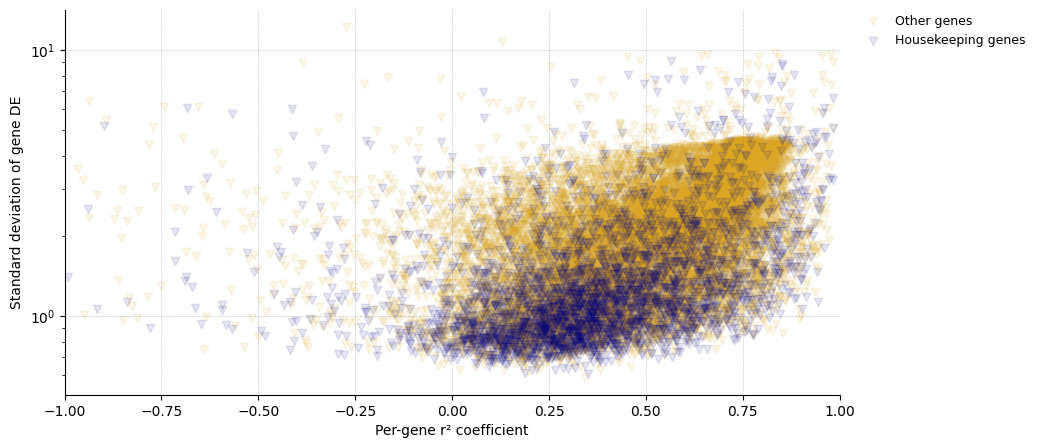

Spearman correlation: SpearmanrResult(correlation=0.5035628347232267, pvalue=0.0)


In [57]:
show_per_gene_performance(r2)

The more dispersed the DE of a gene, the more easily it can be predicted. Let's now see the performance obtained when adding the BMS layers.

In [58]:
r2_bms = cross_validate(X, torch.FloatTensor(data), add_bms_layers=True, seed=95)

0.665: 100%|██████████| 40/40 [09:47<00:00, 14.69s/it]


Relative validation error: 0.9476412077382337


0.685: 100%|██████████| 40/40 [09:46<00:00, 14.66s/it]


Relative validation error: 0.8484557846746591


0.683: 100%|██████████| 40/40 [09:43<00:00, 14.59s/it]


Relative validation error: 0.5533026212438912


0.677: 100%|██████████| 40/40 [09:43<00:00, 14.60s/it]

Relative validation error: 0.7870058247140329
Average relative error: 0.773936797758665
Average relative corrected error: 0.6576013491126356
Median R2: 0.2188500165939331


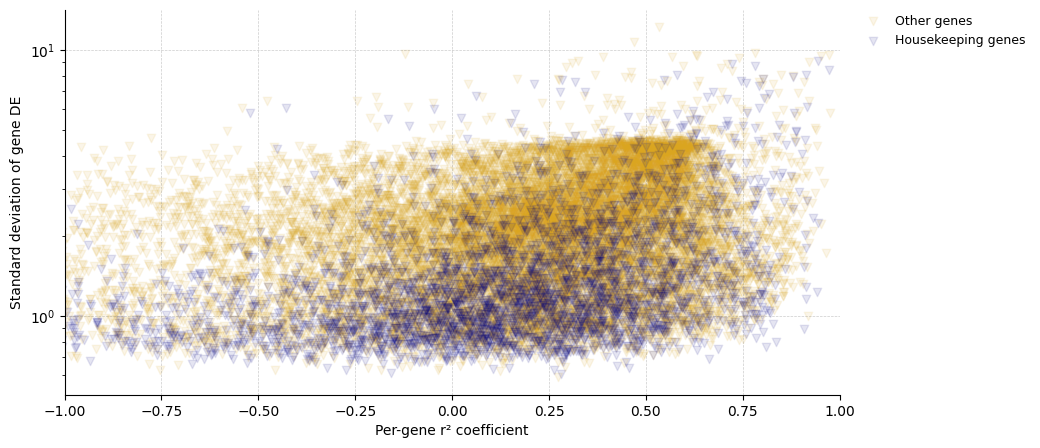

Spearman correlation: SpearmanrResult(correlation=0.30817558774071463, pvalue=0.0)


In [59]:
show_per_gene_performance(r2_bms)

It appears that training the model for 5 epochs is not sufficient to reach desired performance. It is possible to drastically improve the performance of BMS layers, however it requires much longer training times. On the other hand, it remains important to note that training this BMS architecture for more epochs introduces heavy risks of overfitting, especially for the genes with many annotations (i.e., genes involved in many pathways are regulated by many transcription factors), as the sparse linear layers contain more parameters for predicting their DE. We did not find the optimal number of epochs to train this architecture due to time constraints.

In [60]:
# Save per-gene r2 scores for ensembling
np.save('validation-r2-dl40.npy', r2)
np.save('validation-r2-dl-bio-nets.npy', r2_bms)

<h1 id="model-reliability">Model reliability</h1> <a class="anchor" id="model-reliability"></a>

<h2 id="interpretability-grn">The NN's prediction mechanism reflects gene regulatory relationships</h2> <a class="anchor" id="interpretability-grn"></a>

The first question we had in mind while questioning the reliability of our model is, does it rely on meaningful relationships between genes, or does it rely on spurious correlations instead? In particular, how do the input features for a particular gene influence the prediction for all other genes?

<span style="color:crimson;">Saliency maps</span> can answer that question, by measuring the change in one of the output variables caused by a change in each of the input variables. In this notebook we use the [Integrated Gradients](#ref_integrated_gradients) method instead, which proves to be more robust. To compute the relationship between genes learned by the model, we rely on the sample-centric MLP, which maps a `(batch_size, n_genes, 2)`-dimensional input to a tensor of shape `(batch_size, n_genes, 2)`. Because there are multiple input channels as well as multiple output channels, we take the absolute values and average the results over the channels, so we end up with a score matrix of shape `(n_genes, n_genes)`.

However, the Integrated Gradients method is very slow in the present case, and cannot be applied for each gene. To solve this issue, we first download a goldstandard gene regulatory network, and compare our score matrix against the 5 columns in the goldstandard network with the most annotations. This allows a fair evaluation since these columns should contain very few false negatives (false positives should in principle not exist, since annotated regulatory relationships are based on strong experimental evidence).

Are the BMS layers really needed? To find out, let's first train the model for 200 epochs, without prior biological knowledge (without BMS layer).

In [61]:
model = train(X, torch.FloatTensor(data), np.arange(len(X)), SEED, n_iter=200, add_bms_layers=False)

0.524: 100%|██████████| 200/200 [05:12<00:00,  1.56s/it]


We next fetch the goldstandard gene regulatory network from [CollecTRI](#ref_collectri):

In [62]:
# Download GRN
df_collectri = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")

# Iterate over the edges (regulatory relationships)
edge_idx = set()
for gene_a, gene_b in zip(df_collectri['source'], df_collectri['target']):
    if (gene_a not in gene_name_dict) or (gene_b not in gene_name_dict):
        continue  # Consider only gene names that are present in the training data
    i = gene_name_dict[gene_a]  # Index of first gene
    j = gene_name_dict[gene_b]  # Index of second gene
    edge_idx.add((i, j))
edge_idx = np.asarray(list(edge_idx), dtype=int)

# Convert list of edges into an adjacency matrix
grn = np.zeros((len(gene_names), len(gene_names)))
grn[edge_idx[:, 0], edge_idx[:, 1]] = 1

# Remove rows and columns with no annotation
grn_mask = np.logical_or(grn.sum(axis=0) > 0, grn.sum(axis=1) > 0)
grn = grn[grn_mask, :][:, grn_mask]

Next we attempt at building a GRN (or at least 5 columns of its adjacency matrix) by averaging the feature attribution vectors across all inputs. We sample inputs at random based on the null distribution.

In [63]:
# Set seed
plant_seed(SEED)

# Initialize NN explainer
baseline = torch.zeros((1, X.size()[1], X.size()[2]))
if USE_GPU:
    baseline = baseline.cuda()
ig = IntegratedGradients(model)

# Sort the columns of the goldstandard network based on the coverage of annotations
idx = np.argsort(np.sum(grn, axis=0))[::-1]

all_z_target, all_z_pred = [], []
for k in range(5):
    
    # Select column `j` from the goldstandard GRN
    j = int(idx[k])
    z_target = grn[:, j]
    z_target[j] = np.nan  # Assume that a gene cannot regulate itself -> will be filtered out later
    all_z_target.append(z_target)
    
    # Compute feature attribution vectors for many input points and average over the results
    z_pred = np.zeros(len(gene_names))
    for i in tqdm.tqdm(range(1000)):
        # Generate random input based on the null distribution
        input_ = background_noise(X.size()[1], X.size()[2], device=baseline.device)
        
        # Compute feature attribution
        attributions = ig.attribute(input_, baseline, target=j, return_convergence_delta=False)
        # An alternative is to use input samples from the training set:
        # attributions = ig.attribute(X[i, ...], baseline, target=j, return_convergence_delta=False)
        # By averaging across all samples from the same cell type, one can build a biological network
        # that is cell type-specific.
        
        z_pred += np.mean(np.abs(np.squeeze(attributions.cpu().data.numpy())), axis=1)
    all_z_pred.append(z_pred[grn_mask])
    
# Compute performance metrics
all_z_target = np.concatenate(all_z_target, axis=0)
all_z_pred = np.concatenate(all_z_pred, axis=0)
mask = ~np.isnan(all_z_target)  # Discard self-regulations
print(f'AUROC: {roc_auc_score(all_z_target[mask], all_z_pred[mask])}')
print(f'AUPR : {average_precision_score(all_z_target[mask], all_z_pred[mask])}')

100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


AUROC: 0.5513374778120931
AUPR : 0.03704171581388714


While performance seems low, it is in line with what can be found in the literature, such as for the inference of GRNs from [human lymphoblastoid cell lines](#ref_lcl) for example. Let's compare these results with an existing GRN inference method, [PORTIA](#ref_portia), to make sure that the associations between genes cannot be simply uncovered from the correlations between the DE values in the training set.

In [64]:
# Run PORTIA to infer a GRN from the training data
dataset = portia.GeneExpressionDataset()
for exp_id, x in enumerate(data[:, grn_mask]):
    dataset.add(portia.Experiment(exp_id, x))
M_bar = portia.run(dataset, method='fast')

# Sort the columns of the goldstandard network based on the coverage of annotations
idx = np.argsort(np.sum(grn, axis=0))[::-1]

all_z_target_portia, all_z_pred_portia = [], []
for k in tqdm.tqdm(range(5)):
    
    # Select column `j` from the goldstandard GRN
    j = int(idx[k])
    z_target = np.squeeze(grn[:, j])
    z_target = np.delete(z_target, j)  # Assume that a gene cannot regulate itself
    all_z_target_portia.append(z_target)
    
    z_pred = M_bar[:, j]
    z_pred = np.delete(z_pred, j)  # Assume that a gene cannot regulate itself
    all_z_pred_portia.append(z_pred)

# Compute performance metrics
all_z_target_portia = np.concatenate(all_z_target_portia, axis=0)
all_z_pred_portia = np.concatenate(all_z_pred_portia, axis=0)
print(f'AUROC: {roc_auc_score(all_z_target_portia, all_z_pred_portia)}')
print(f'AUPR : {average_precision_score(all_z_target_portia, all_z_pred_portia)}')

/opt/conda/lib/python3.10/site-packages/portia/core.py:138: UserWarning: Expression data contain negative values. It is recommended to provide raw data instead.
  warnings.warn(


Gene expression matrix of shape (614, 4370)


100%|██████████| 5/5 [00:00<00:00, 1975.09it/s]

AUROC: 0.4937345697244925
AUPR : 0.031807541337723996


<span style="color:crimson;">While our NN was not specifically designed to infer GRNs, and its architecture was deprived of the BMS layers, it still outperformed PORTIA</span> (which does not perform better than random), therefore demonstrating its ability to learn from relevant associations between genes. Intuitively, it also means that perturbating the input values for a particular gene encoding for a transcription factor is likely to influence the prediction for its target genes.

We still need to assess whether these results are significant. For that purpose, we performed a permutation test by randomly shuffling the scores, computing AUROC and AUPR and repeating this operation many times. P-value is defined as the number of permutations for which predictions are doing worse than the shuffled predictions. To assess performance within the test, we use an overall score metric that we simply define as the geometric mean of the AUROC and AUPR as in [this study](#ref_portia).

In [65]:
# We define the overall score
overall_score = lambda pred, target: math.sqrt(roc_auc_score(target, pred) * average_precision_score(target, pred))

# Permutation test
scores = []
for _ in tqdm.tqdm(range(10000)):
    shuffle_z_pred = np.copy(all_z_pred)
    np.random.shuffle(shuffle_z_pred)  # Shuffle the predictions
    mask = ~np.isnan(all_z_target)  # Discard self-regulations
    scores.append(overall_score(shuffle_z_pred[mask], all_z_target[mask]))  # Assess performance
scores = np.asarray(scores)

100%|██████████| 10000/10000 [02:06<00:00, 79.01it/s]


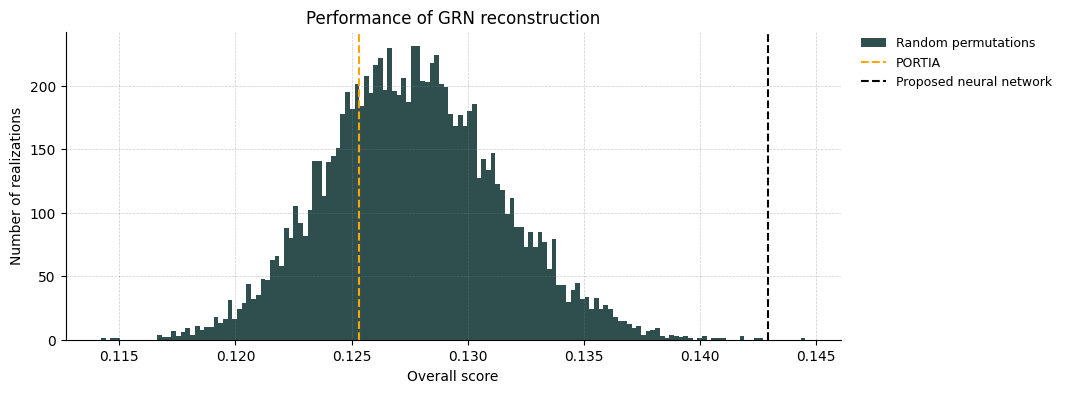

Permutation test:
p-value (PORTIA): 0.7257
p-value (Neural network): 0.0001


In [66]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
mask = ~np.isnan(all_z_target)  # Discard self-regulations
plt.hist(scores, bins=150, label='Random permutations', color='darkslategrey')
plt.axvline(x=overall_score(all_z_pred_portia, all_z_target_portia), color='orange', label='PORTIA', linestyle='--')
plt.axvline(x=overall_score(all_z_pred[mask], all_z_target[mask]), color='black', label='Proposed neural network', linestyle='--')
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel('Overall score')
plt.ylabel('Number of realizations')
plt.title('Performance of GRN reconstruction')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(prop=prop, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()

print('Permutation test:')
print(f'p-value (PORTIA): {np.mean(overall_score(all_z_pred_portia, all_z_target_portia) < scores)}')
print(f'p-value (Neural network): {np.mean(overall_score(all_z_pred[mask], all_z_target[mask]) < scores)}')

Permutation test confirms the significance of our results for GRN inference.

<h2 id="robustness">The NN is robust against random fluctuations of the inputs</h2> <a class="anchor" id="robustness"></a>

To better support the results obtained in the previous section, let's assess the robustness of the predictions when injecting the input data with random noise sampled from the null distribution. Because the input features are not DE values directly, but target encoding of DE values, directly sampling from the null distribution would produce overdispersed noise.

Assuming noise is i.i.d. across samples, we can simulate this by simply averaging noise. For target encoding of the cell types, there are at least 4 samples (corresponding to the 4 lymphoid cell types). For the target encoding of compounds, there are up to 144 compounds, therefore almost completely canceling out the noise terms. However, let's simulate the most pessimistic scenario and assuming there are only 4 samples to learn the target encodings for *both* cell types and compounds.

In [67]:
# Set seed
plant_seed(SEED)

pred_before = []
pred_after = []
for i in tqdm.tqdm(range(len(X))):
    input_ = X[i, :, :].unsqueeze(0)
    input_noisy = torch.clone(input_)
    for _ in range(4):  # Simulate the 4 samples used to learn the target encodings
        input_noisy += 0.25 * background_noise(1, X.size()[1], X.size()[2], device=X.device)
    output = np.squeeze(model.forward(input_).cpu().data.numpy())
    output_noisy = np.squeeze(model.forward(input_noisy).cpu().data.numpy())
    pred_before.append(output)
    pred_after.append(output_noisy)
pred_before = np.asarray(pred_before).flatten()
pred_after = np.asarray(pred_after).flatten()

100%|██████████| 614/614 [00:03<00:00, 196.00it/s]


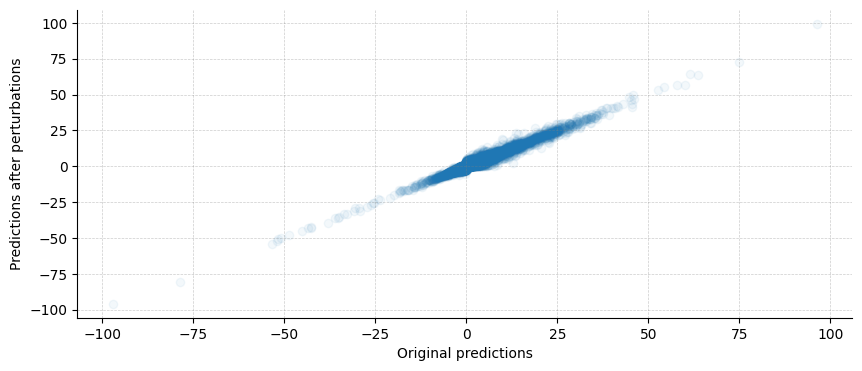

Pearson correlation: (0.9719202802888501, 0.0)


In [68]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
plt.scatter(pred_before[::100], pred_after[::100], alpha=0.05)  # Take only a subset of the points for efficiency purposes
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Original predictions')
plt.ylabel('Predictions after perturbations')
plt.show()
print(f'Pearson correlation: {scipy.stats.pearsonr(pred_before, pred_after)}')

Finally, we observe a <span style="color:crimson;">strong robustness of the predictions against the background noise</span>, as confirmed by a Pearson correction coefficient of 97%.

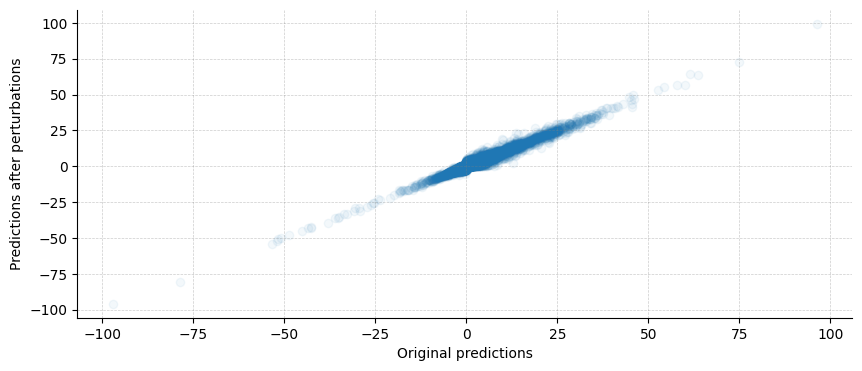

Pearson correlation: (0.9719202802888501, 0.0)


In [69]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
plt.scatter(pred_before[::100], pred_after[::100], alpha=0.05)  # Take only a subset of the points for efficiency purposes
plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Original predictions')
plt.ylabel('Predictions after perturbations')
plt.show()
print(f'Pearson correlation: {scipy.stats.pearsonr(pred_before, pred_after)}')

<h1 id="make-submission">Make submission</h1> <a class="anchor" id="make-submission"></a>

#### Train final models

Let's train the final models that will be used for making our submission. In order to stabilize the predictions, we train the exact same model on the whole training set multiple times, and we report the median of the predictions.

In [70]:
SUBMISSION_NAME = 'dl40'  # Replace based on which submission you wish to reproduce
assert SUBMISSION_NAME in {'dl40', 'dl200', 'dl-bio-nets'}

models = []
for i in range(30):
    seed = i
    if SUBMISSION_NAME == 'dl40':
        model = train(X, torch.FloatTensor(data), np.arange(len(X)), seed, n_iter=40)
    elif SUBMISSION_NAME == 'dl200':
        model = train(X, torch.FloatTensor(data), np.arange(len(X)), seed, n_iter=200)
    else:
        model = train(X, torch.FloatTensor(data), np.arange(len(X)), seed, add_bms_layers=True, n_iter=40)
    model = model.cpu()
    model.eval()
    models.append(model)
    torch.cuda.empty_cache()

0.715: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


#### Predict on test set

In [71]:
# Load ID mapping
id_map = []
with open(os.path.join(DATA_FOLDER, 'id_map.csv'), 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        id_map.append(line.rstrip().split(','))
        assert len(id_map[-1]) == 3

# Target encoding of the cell types and compounds
X = []
for _, cell_type, sm_name in id_map:
    X.append([cell_type, sm_name])
X = torch.FloatTensor(encoder.transform(np.asarray(X)))

transform LOO encoders: 100%|██████████| 18211/18211 [01:25<00:00, 212.10it/s]


In [72]:
# Make submission
with open(f'{SUBMISSION_NAME}.csv', 'w') as f:
    f.write(f'id,{",".join(gene_names)}\n')
    for i, (id_, cell_type, sm_name) in tqdm.tqdm(enumerate(id_map), desc='Submission'):

        # Predict on test sample using a simple ensembling strategy:
        # take the median of the predictions across the different models
        y_hat = []
        for model in models:
            model = model.cpu()
            x = X[i, :]
            y_hat.append(np.squeeze(model.forward(x.unsqueeze(0)).cpu().data.numpy()))
        y_hat = np.median(y_hat, axis=0)

        # Write predictions in output file
        values = [f'{x:.5f}' for x in y_hat]
        f.write(f'{id_},{",".join(values)}\n')

Submission: 255it [00:31,  8.20it/s]


<h1 id="future_work">Future work</h1> <a class="anchor" id="future_work"></a>

There are numerous ideas that we did not have the time to properly implement and that we deem important for future research. We recommend readers drawing inspiration from this notebook to explore in the following directions:
- Tune the number of epochs and introducing classical regularization (e.g., dropout) to extract the best performance out of the BMS layers.
- Ensure that there is no imbalance between the performances of the different genes. For example, housekeeping genes should not be mispredicted more often than other genes. If this proves to be the case, devise a per-gene regularization technique that attaches more importance to overfitted genes. The level of regularization can also be determined a priori based on how confident we are that a gene is DE. See [this section](#housekeeping_genes) for more details on how to do this.
- Optimize the speed of the sparse linear layers to accelerate the development cycle.
- Work with t-statistics instead of DE values, as they have more convenient mathematical properties. Also, replacing the DE values by the t-statistics should alleviate the presence of outliers. While we did not observe any improvement in public LB score while trying to do so ourselves, we still think modeling the t-statistics directly should help in the design of more principled approaches inspired by probabilistic modeling concepts.

<h1 id="bibliography">Bibliography</h1> <a class="anchor" id="bibliography"></a>

1. <a id="ref_kaggle">Daniel Burkhardt, Andrew Benz, Richard Lieberman, Scott Gigante, Ashley Chow, Ryan Holbrook, Robrecht Cannoodt, Malte Luecken. (2023). Open Problems – Single-Cell Perturbations. Kaggle. https://kaggle.com/competitions/open-problems-single-cell-perturbations</a>
2. <a id='ref_limma'>Ritchie, Matthew E., et al. "limma powers differential expression analyses for RNA-sequencing and microarray studies." Nucleic acids research 43.7 (2015): e47-e47.</a>
3. <a id='ref_voom'>Law, Charity W., et al. "voom: Precision weights unlock linear model analysis tools for RNA-seq read counts." Genome biology 15.2 (2014): 1-17.</a>
4. <a id='ref_verhoeckx'>Verhoeckx, Kitty, et al. "The impact of food bioactives on health: in vitro and ex vivo models." (2015): 338.</a>
5. <a id='ref_housekeeping'>Eisenberg, Eli, and Erez Y. Levanon. "Human housekeeping genes, revisited." TRENDS in Genetics 29.10 (2013): 569-574.</a>
6. <a id='ref_pvalues'>Murdoch, Duncan J., Yu-Ling Tsai, and James Adcock. "P-values are random variables." The American Statistician 62.3 (2008): 242-245.</a>
7. <a id='ref_ibd'>Verplaetse, Nora, et al. "Large sample size and nonlinear sparse models outline epistatic effects in inflammatory bowel disease." Genome Biology 24.1 (2023): 224.</a>
8. <a id='ref_portia'>Antoine Passemiers, Yves Moreau, and Daniele Raimondi. "Fast and accurate inference of gene regulatory networks through robust precision matrix estimation." Bioinformatics 38.10 (2022): 2802-2809.</a>
9. <a id='ref_ebayes'>Smyth, Gordon K. "Linear models and empirical bayes methods for assessing differential expression in microarray experiments." Statistical applications in genetics and molecular biology 3.1 (2004).</a>
10. <a id='ref_ldha'>Cui, Xin-gang, et al. "HIF1/2α mediates hypoxia-induced LDHA expression in human pancreatic cancer cells." Oncotarget 8.15 (2017): 24840.</a>
11. <a id='ref_hypoxia'>Chien, Wenwen, et al. "Growth inhibition of pancreatic cancer cells by histone deacetylase inhibitor belinostat through suppression of multiple pathways including HIF, NFkB, and mTOR signaling in vitro and in vivo." Molecular carcinogenesis 53.9 (2014): 722-735.</a>
12. <a id='ref_integrated_gradients'>Sundararajan, Mukund, Ankur Taly, and Qiqi Yan. "Axiomatic attribution for deep networks." International conference on machine learning. PMLR, 2017.</a>
13. <a id='ref_collectri'>Mueller-Dott, Sophia, et al. "Expanding the coverage of regulons from high-confidence prior knowledge for accurate estimation of transcription factor activities." bioRxiv (2023): 2023-03.</a>
14. <a id='ref_lcl'>Siahpirani, Alireza F., and Sushmita Roy. "A prior-based integrative framework for functional transcriptional regulatory network inference." Nucleic acids research 45.4 (2017): e21-e21.</a>